# Objective
* 20190213:
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Instead of using last value method, we use prophet package to predict
* 20241203: Diff from StockPricePrediction_v2_prophet.ipynb: Here we use neuralprophet.

In [1256]:
%matplotlib inline

import math
import matplotlib
import multiprocessing
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as pyo
import pickle
import pylab
import scipy.stats as stats
import seaborn as sns
import time
import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import date, datetime, timedelta
from neuralprophet import NeuralProphet, set_log_level, set_random_seed
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
# from tqdm import tqdm_notebook

#### Input params ##################
stk_path = "./data/VTI_20130102_20181231.csv"
H = 21                          # Forecast horizon
train_size = 252*3              # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set
n_changepoints_list = [2, 5, 10, 15, 20]     # for hyperparameter tuning
fourier_order_list = [2, 4, 6, 8, 10]                 # for hyperparameter tuning
holidays_path = "../StockPricePrediction_fh21/data/holidays.csv"                       # csv file containing holidays in the US
window_list = [0, 1, 2]         # Event parameters. For hyperparameter tuning
n_lags_list = [0, 2, 5, 10]     # Autoregression parameters. For hyperparameter tuning

fontsize = 14
ticklabelsize = 14

random_seed = 101
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [1257]:
# Disable logging messages unless there is an error
set_log_level("ERROR")

In [1258]:
print("We will start forecasting on day %d" % (train_val_size+1))

We will start forecasting on day 1009


# Common functions

In [1259]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def get_preds_nprophet(df, H, n_changepoints=10, fourier_order=None, holidays=None, lower_window=0, upper_window=0, n_lags=None):
    """
    Use NProphet to forecast for the next H timesteps, starting at df[len(df)]
    Inputs
        df: dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H : forecast horizon
        n_changepoints          : number of trend changepoints
        fourier_order           : determines how quickly seasonality can change
        holidays                : dataframe containing event you will like to model. 
                                  Must have 'event' and 'ds' columns
        lower_window           : Determines the lower window where the event affects the results
        upper_window           : Determines the upper window where the event affects the results
        n_lags                 : Autoregression parameter
    Outputs
        A list of predictions
    """
    # Fit nprophet model
    if n_lags is not None:
        m = NeuralProphet(n_changepoints=n_changepoints, n_lags=n_lags)
    else:
        m = NeuralProphet(n_changepoints=n_changepoints)
   
    if fourier_order is not None:
        m = m.add_seasonality(name="monthly", period=30.5, fourier_order=fourier_order)

    if holidays is not None:
        m.add_events("hols", lower_window=lower_window, upper_window=upper_window)
        history_df = m.create_df_with_events(df, holidays)
        m.fit(history_df)
        future = m.make_future_dataframe(history_df, events_df=holidays, n_historic_predictions=True, periods=H)
    else:
        m.fit(df)
        # Make future dataframe
        future = m.make_future_dataframe(df, n_historic_predictions=True, periods=H)
    
    # Predict
    forecast = m.predict(future) # Note this prediction includes the original dates

    return forecast['yhat1'][len(df):len(df)+H]
    
def get_error_metrics(df, df_adj_close, H, train_size, val_size, n_changepoints=10, fourier_order=None, 
                      holidays=None, lower_window=0, upper_window=0, n_lags=None):
    """
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for NProphet)
        df_adj_close           : same as df, but with additional 'adj_close' column
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        n_changepoints         : number of trend changepoints
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing events you will like to model. 
                                 Must have 'event' and 'ds' columns
        lower_window           : Determines the lower window where the event affects the results
        upper_window           : Determines the upper window where the event affects the results
        n_lags                 : Autoregression parameter
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    assert len(df) == train_size + val_size
    
    # Predict using Prophet, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
#     preds_dict = {}
    
#     rmse_mean, mape_mean, mae_mean = get_preds_nprophet_parallelized(df, 
#                                                                        df_adj_close, 
#                                                                        H, 
#                                                                        train_size, 
#                                                                        n_changepoints, 
#                                                                        fourier_order, 
#                                                                        holidays,
#                                                                        lower_window,
#                                                                        upper_window,
#                                                                        n_lags)
    rmse_mean, mape_mean, mae_mean = get_preds_nprophet_unparallelized(df, 
                                                                       df_adj_close, 
                                                                       H, 
                                                                       train_size, 
                                                                       n_changepoints, 
                                                                       fourier_order, 
                                                                       holidays,
                                                                       lower_window,
                                                                       upper_window,
                                                                       n_lags)

    return rmse_mean, mape_mean, mae_mean, _

def hyperparam_tune_cp(df, df_adj_close, H, train_size, val_size, n_changepoints_list):
    """
    Hyperparameter tuning - changepoint
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for NProphet)
        df_adj_close           : same as df, but with additional 'adj_close' column
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        n_changepoints_list: list of n_changepoints values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for n_changepoints in tqdm.notebook.tqdm(n_changepoints_list):
        print("n_changepoints = " + str(n_changepoints))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, df_adj_close, H, train_size, val_size, n_changepoints)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
    
    # Create results dataframe
    results = pd.DataFrame({'n_changepoints_list': n_changepoints_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    
    # Return hyperparam corresponding to lowest error metric
    return n_changepoints_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_fo(df, df_adj_close, H, train_size, val_size, fourier_order_list):
    """
    Hyperparameter tuning - fourier order
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for NProphet)
        df_adj_close           : same as df, but with additional 'adj_close' column
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        fourier_order_list     : list of fourier_order values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for fourier_order in tqdm.notebook.tqdm(fourier_order_list):
        print("fourier_order = " + str(fourier_order))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, df_adj_close, H, train_size, val_size, 10, fourier_order)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'fourier_order': fourier_order_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return fourier_order_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_wd(df, df_adj_close, H, train_size, val_size, window_list, holidays):
    """
    Hyperparameter tuning - upper and lower windows for holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        df_adj_close           : same as df, but with additional 'adj_close' column
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        window_list            : list of upper and lower window values to try
        holidays               : dataframe containing events you will like to model. 
                                 Must have 'event' and 'ds' columns
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for window  in tqdm.notebook.tqdm(window_list):
        print()
        print("window = " + str(window))
        
        if window is None:
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df=df, 
                                                                  df_adj_close=df_adj_close,
                                                                  H=H, 
                                                                  train_size=train_size, 
                                                                  val_size=val_size, 
                                                                  holidays=None)
        else:
            # Add lower_window and upper_window which extend the holiday out to 
            # [lower_window, upper_window] days around the date
            lower_window = -window
            upper_window = +window
        
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df=df, 
                                                                  df_adj_close=df_adj_close,
                                                                  H=H, 
                                                                  train_size=train_size, 
                                                                  val_size=val_size, 
                                                                  holidays=holidays,
                                                                  lower_window=lower_window,
                                                                  upper_window=upper_window)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'window': window_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return window_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_nl(df, df_adj_close, H, train_size, val_size, n_lags_list):
    """
    Hyperparameter tuning - n_lags (autoregression parameter)
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for NProphet)
        df_adj_close           : same as df, but with additional 'adj_close' column
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        n_lags_list            : list of n_lag values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for n_lags in tqdm.notebook.tqdm(n_lags_list):
        print("n_lags = " + str(n_lags))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, df_adj_close, H, train_size, val_size, n_lags=n_lags)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'n_lags': n_lags_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return n_lags_list[np.argmin(rmse_mean_list)], results


def hyperparam_tune_cp_fo_wd_nl(df, df_adj_close, H, train_size, val_size, n_changepoints_list, 
                             fourier_order_list, window_list, holidays_list, n_lags_list):
    """
    Hyperparameter tuning - changepoint, fourier_order, holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for NProphet)
        df_adj_close           : same as df, but with additional 'adj_close' column
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        n_changepoints_list    : list of n_changepoint values to try
        fourier_order_list     : list of fourier_order values to try
        window_list            : list of upper and lower window values to try
        holidays_list          : try with or without dataframe containing holidays you will like to model. 
                                 Must have 'event' and 'ds' columns
        n_lags_list            : list of n_lags values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    cp_list = []
    fo_list = []
    wd_list = []
    nl_list = []
    hl_list = []
    for n_changepoints in tqdm.notebook.tqdm(n_changepoints_list):
        for fourier_order in tqdm.notebook.tqdm(fourier_order_list):
            for window in tqdm.notebook.tqdm(window_list):
                for n_lags in tqdm.notebook.tqdm(n_lags_list):
                    for holidays in holidays_list:
                
                        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          df_adj_close, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          n_changepoints=n_changepoints, 
                                                                          fourier_order=fourier_order, 
                                                                          holidays=holidays,
                                                                          lower_window=window,
                                                                          upper_window=window,
                                                                          n_lags=n_lags)
                        rmse_mean_list.append(rmse_mean)
                        mape_mean_list.append(mape_mean)
                        mae_mean_list.append(mae_mean)
                        cp_list.append(n_changepoints)
                        fo_list.append(fourier_order)
                        wd_list.append(window)
                        nl_list.append(n_lags)
                        hl_list.append(holidays)
        
    # Return hyperparam corresponding to lowest error metric
    results = pd.DataFrame({'n_changepoints': cp_list, 
                            'fourier_order': fo_list,
                            'window': wd_list,
                            'n_lags': nl_list,
                            'holidays': hl_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list
                            })
    temp = results[results['rmse'] == results['rmse'].min()]
    n_changepoints_opt = temp['n_changepoints'].values[0]
    fourier_order_opt = temp['fourier_order'].values[0]
    window_opt = temp['window'].values[0]
    n_lags_opt = temp['n_lags'].values[0]
    holidays_opt = temp['holidays'].values[0]
    
    return n_changepoints_opt, fourier_order_opt, window_opt, n_lags_opt, holidays_opt, results

In [1260]:
def processInput(i, df, df_adj_close, H, n_changepoints, fourier_order, holidays, lower_window, upper_window, n_lags):
    
    preds_list = get_preds_nprophet(df[i-train_size:i], H, n_changepoints, fourier_order, holidays, lower_window, upper_window, n_lags)
    
    # Convert back to price
    est_adj_close = []
    prev_tg = df_adj_close.loc[i-1, 'adj_close']
    for n in range(H):
        est_adj_close.append((float(preds_list.iloc[n])/100+1)*prev_tg)
        prev_tg = (float(preds_list.iloc[n])/100+1)*prev_tg
    
    # Compute error metrics
    rmse = get_rmse(df_adj_close[i:i+H]['adj_close'], est_adj_close)
    mape = get_mape(df_adj_close[i:i+H]['adj_close'], est_adj_close)
    mae = get_mae(df_adj_close[i:i+H]['adj_close'], est_adj_close)
    
    return (rmse, mape, mae)

def get_preds_nprophet_parallelized(df, df_adj_close, H, train_size, n_changepoints=10, fourier_order=None, 
                                      holidays=None, lower_window=0, upper_window=0, n_lags=None):
    """
    This is a parallelized implementation of get_preds_prophet.
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        df_adj_close           : same as df, but with additional 'adj_close' column
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        n_changepoints         : number of trend changepoints
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
        lower_window           : Determines the lower window where the event affects the results
        upper_window           : Determines the upper window where the event affects the results
        n_lags                 : Autoregression parameter
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    inputs = range(train_size, len(df)-H, int(H/2))

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i, df, df_adj_close, H, n_changepoints, fourier_order, 
                                                               holidays, lower_window, upper_window, n_lags) for i in inputs)
    # results has format [(rmse1, mape1, mae1), (rmse2, mape2, mae2), ...]

    rmse = [errors[0] for errors in results]
    mape = [errors[1] for errors in results]
    mae = [errors[2] for errors in results]
    
    return np.mean(rmse), np.mean(mape), np.mean(mae)

def get_preds_nprophet_unparallelized(df, df_adj_close, H, train_size, n_changepoints=10, fourier_order=None, 
                                      holidays=None, lower_window=0, upper_window=0, n_lags=None):
    """
    This is a unparallelized implementation of get_preds_prophet.
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        df_adj_close           : same as df, but with additional 'adj_close' column
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        n_changepoints         : number of trend changepoints
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
        lower_window           : Determines the lower window where the event affects the results
        upper_window           : Determines the upper window where the event affects the results
        n_lags                 : Autoregression parameter
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    inputs = range(train_size, len(df)-H, int(H/2))
    print('len(inputs) = ', len(inputs))

    rmse = []
    mape = []
    mae = []
    for index, value in enumerate(inputs):
        print('Starting new day...')
        print('n_changepoints='+str(n_changepoints)+', fourier_order='+str(fourier_order)+', lower_window='+str(lower_window)+', n_lags='+str(n_lags))
        print('day = ' + str(value) + ", which is index " + str(index) + " out of " + str(len(inputs)))
        results = processInput(value, df, df_adj_close, H, n_changepoints, fourier_order, 
                               holidays, lower_window, upper_window, n_lags)
        print('results = ', results)
        rmse.append(results[0])
        mape.append(results[1])
        mae.append(results[2])

    return np.mean(rmse), np.mean(mape), np.mean(mae)

# Load data

In [1261]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

# Get size of dataframe
print("len(df) = " + str(len(df)))

df.head(10)

len(df) = 1509


,date,open,high,low,close,adj_close,volume
0,2013-01-02 00:00:00,74.529999,75.150002,74.500000,75.139999,66.997757,5037200
1,2013-01-03 00:00:00,75.120003,75.370003,74.839996,75.029999,66.899689,2634600
2,2013-01-04 00:00:00,75.139999,75.519997,74.989998,75.410004,67.238510,2512900
3,2013-01-07 00:00:00,75.180000,75.279999,74.949997,75.209999,67.060173,2511200
4,2013-01-08 00:00:00,75.110001,75.180000,74.699997,75.010002,66.881859,1407900
5,2013-01-09 00:00:00,75.190002,75.410004,75.110001,75.239998,67.086937,1421900
6,2013-01-10 00:00:00,75.620003,75.769997,75.220001,75.760002,67.550591,1403700
7,2013-01-11 00:00:00,75.760002,75.800003,75.510002,75.769997,67.559486,1248500
8,2013-01-14 00:00:00,75.750000,75.800003,75.440002,75.690002,67.488159,2745100
9,2013-01-15 00:00:00,75.400002,75.889999,75.339996,75.830002,67.612984,1109100


In [1262]:
df['date'].min(), df['date'].max() 

(Timestamp('2013-01-02 00:00:00'), Timestamp('2018-12-28 00:00:00'))

Text(0, 0.5, 'USD')

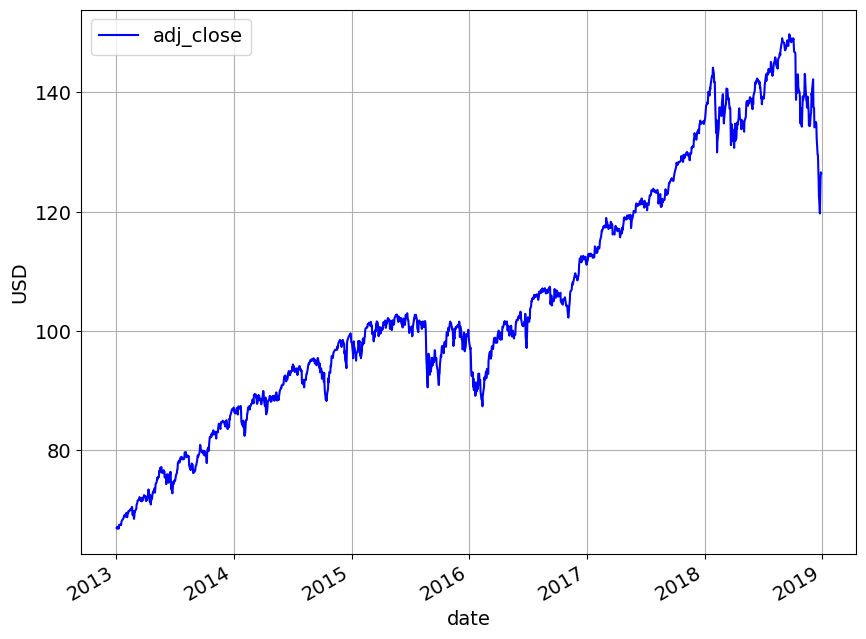

In [1263]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [1264]:
# Create returns column
df['daily_ret'] = 100.0 * ((df['adj_close'] / df['adj_close'].shift(1)) - 1)
df

,date,open,high,low,close,adj_close,volume,daily_ret
0,2013-01-02 00:00:00,74.529999,75.150002,74.500000,75.139999,66.997757,5037200,NaN
1,2013-01-03 00:00:00,75.120003,75.370003,74.839996,75.029999,66.899689,2634600,-0.146375
2,2013-01-04 00:00:00,75.139999,75.519997,74.989998,75.410004,67.238510,2512900,0.506461
3,2013-01-07 00:00:00,75.180000,75.279999,74.949997,75.209999,67.060173,2511200,-0.265230
4,2013-01-08 00:00:00,75.110001,75.180000,74.699997,75.010002,66.881859,1407900,-0.265901
...,...,...,...,...,...,...,...,...
1504,2018-12-21 00:00:00,126.510002,127.970001,123.120003,123.489998,122.768997,13605000,-2.124119
1505,2018-12-24 00:00:00,121.900002,122.540001,119.669998,119.699997,119.699997,14488500,-2.499817
1506,2018-12-26 00:00:00,120.339996,125.519997,119.349998,125.459999,125.459999,12512300,4.812032
1507,2018-12-27 00:00:00,123.760002,126.589996,121.910004,126.589996,126.589996,16128500,0.900683


In [1265]:
# Drop first row
df = df.dropna(subset=['daily_ret'])
df

,date,open,high,low,close,adj_close,volume,daily_ret
1,2013-01-03 00:00:00,75.120003,75.370003,74.839996,75.029999,66.899689,2634600,-0.146375
2,2013-01-04 00:00:00,75.139999,75.519997,74.989998,75.410004,67.238510,2512900,0.506461
3,2013-01-07 00:00:00,75.180000,75.279999,74.949997,75.209999,67.060173,2511200,-0.265230
4,2013-01-08 00:00:00,75.110001,75.180000,74.699997,75.010002,66.881859,1407900,-0.265901
5,2013-01-09 00:00:00,75.190002,75.410004,75.110001,75.239998,67.086937,1421900,0.306627
...,...,...,...,...,...,...,...,...
1504,2018-12-21 00:00:00,126.510002,127.970001,123.120003,123.489998,122.768997,13605000,-2.124119
1505,2018-12-24 00:00:00,121.900002,122.540001,119.669998,119.699997,119.699997,14488500,-2.499817
1506,2018-12-26 00:00:00,120.339996,125.519997,119.349998,125.459999,125.459999,12512300,4.812032
1507,2018-12-27 00:00:00,123.760002,126.589996,121.910004,126.589996,126.589996,16128500,0.900683


In [1266]:
# Generate Gaussian curve to fit the daily returns
mu = df['daily_ret'].mean()
std = df['daily_ret'].std()
x = np.arange(df['daily_ret'].min(), df['daily_ret'].max(), 0.001)
y = [1/math.sqrt(2*math.pi)/std*math.exp(-((i-mu)**2)/2/(std**2)) for i in x]
gauss_df = pd.DataFrame({'x':x, 'y':y})
print("mean = " + str(mu) + ", std dev = " + str(std))

mean = 0.045433388448427876, std dev = 0.8134088128601797


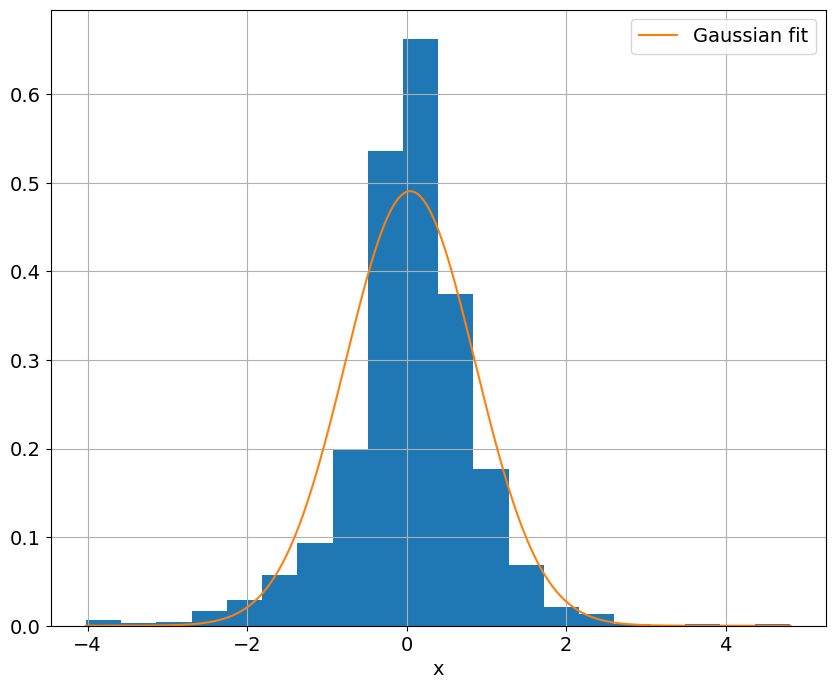

In [1267]:
# Plot histogram of the daily returns
ax = df['daily_ret'].hist(bins=20, density=True)
gauss_df.plot(x='x', y='y', grid=True, ax=ax)
plt.legend(['Gaussian fit'])

In [1268]:
# temp = pd.to_numeric(df['daily_ret'], errors='coerce').to_list()
# fig = ff.create_distplot([temp], 
#                          ['distplot'], 
# #                          bin_size=.1,
# #                          curve_type='normal', # override default 'kde'
#                          )

# # Add title
# fig.update_layout(title_text='Distplot of daily returns with Normal Distribution')
# fig.show()

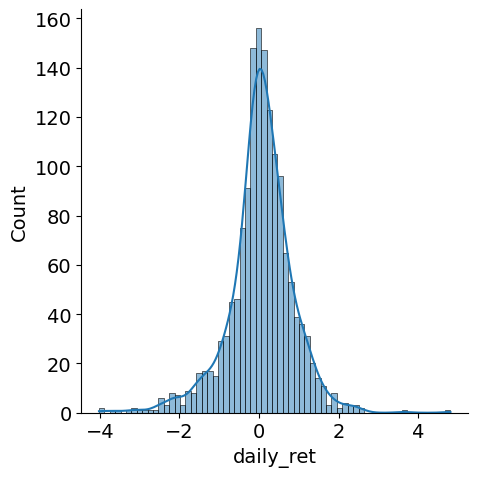

In [1269]:
# Plot distplot using seaborn
sns.displot(data=df, x="daily_ret", kde=True)

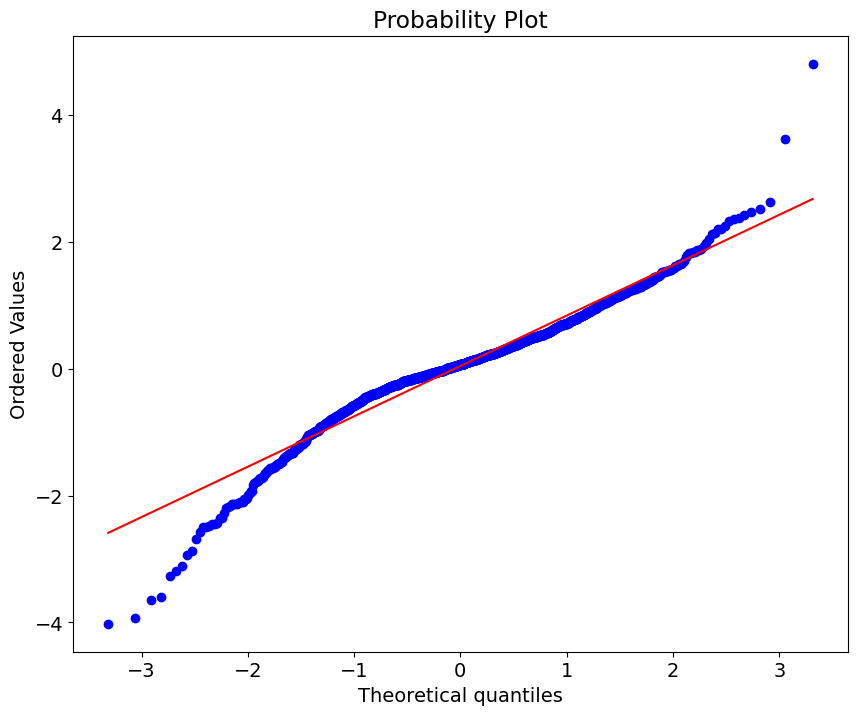

In [1270]:
# Plot QQ plot
stats.probplot(df['daily_ret'][1:], dist="norm", plot=pylab)
pylab.show()

Looks mostly Gaussian, except for the extreme values

In [1271]:
# Plot with plotly
fig = px.scatter(df, x="date", y="daily_ret")
fig.show()

In [1272]:
# Prepare dataframe for NeuralProphet
df_nprophet = df[['date', 'daily_ret']].rename(columns={'date':'ds', 'daily_ret':'y'})
df_nprophet.head()

,ds,y
1,2013-01-03 00:00:00,-0.146375
2,2013-01-04 00:00:00,0.506461
3,2013-01-07 00:00:00,-0.265230
4,2013-01-08 00:00:00,-0.265901
5,2013-01-09 00:00:00,0.306627


# Test for stationarity

Augmented Dickey-Fuller test for stationarity. Taking reference from https://machinelearningmastery.com/time-series-data-stationary-python/

In [1276]:
from statsmodels.tsa.stattools import adfuller

X = df_nprophet['y'].values

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -39.148219
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


Interpretation of results:
* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Since p-value <=0.05, it implies stationarity. 

Also the ADF statistic is less than -3.435 at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

# Predict for a specific H (forecast horizon) and a specific date

In [1234]:
set_random_seed(random_seed) # Set a random seed for reproducibility

In [1235]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_nprophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-04 00:00:00, with forecast horizon H = 21


In [1236]:
# Fit prophet model
m = NeuralProphet()

# Fit nprophet model
# m = NeuralProphet(n_changepoints=10, n_lags=0)
# m = m.add_seasonality(name="monthly", period=30.5, fourier_order=3)


m.set_plotting_backend("plotly-static")
metrics = m.fit(df_nprophet[i-train_val_size:i])

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [1237]:
# Create dataframe with the dates we want to predict
future = m.make_future_dataframe(df_nprophet[i-train_val_size:i], n_historic_predictions=True, periods=H)

According to https://facebook.github.io/prophet/docs/non-daily_data.html, since we do not have weekend data, we should eliminate it from the future dataframe before doing predictions.

In [1238]:
# # Eliminate weekend from future dataframe
# future['day'] = future['ds'].dt.weekday
# future = future[future['day']<=4]

# Predict
forecast = m.predict(future)
forecast.tail()

Predicting: 32it [00:00, ?it/s]

,ds,y,yhat1,trend,season_yearly,season_weekly
1024,2017-01-26,NaN,0.127048,-2.834486,-0.030137,2.991670
1025,2017-01-27,NaN,0.116333,-2.834145,-0.019184,2.969662
1026,2017-01-30,NaN,0.115361,-2.833122,0.015234,2.933249
1027,2017-01-31,NaN,0.214306,-2.832781,0.027044,3.020043
1028,2017-02-01,NaN,0.202762,-2.832440,0.038936,2.996265


python(12225) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


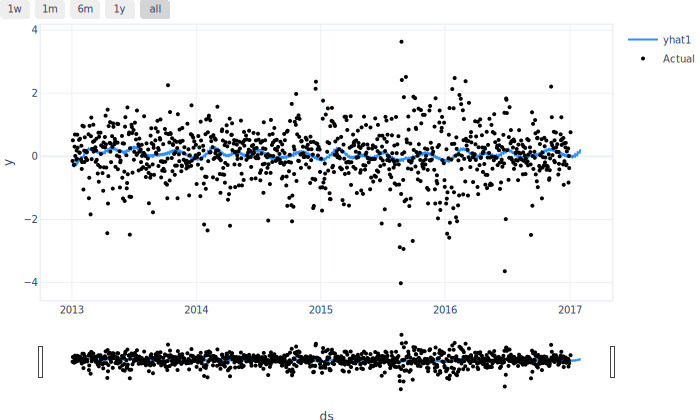

In [1239]:
# Plot
m.plot(forecast)

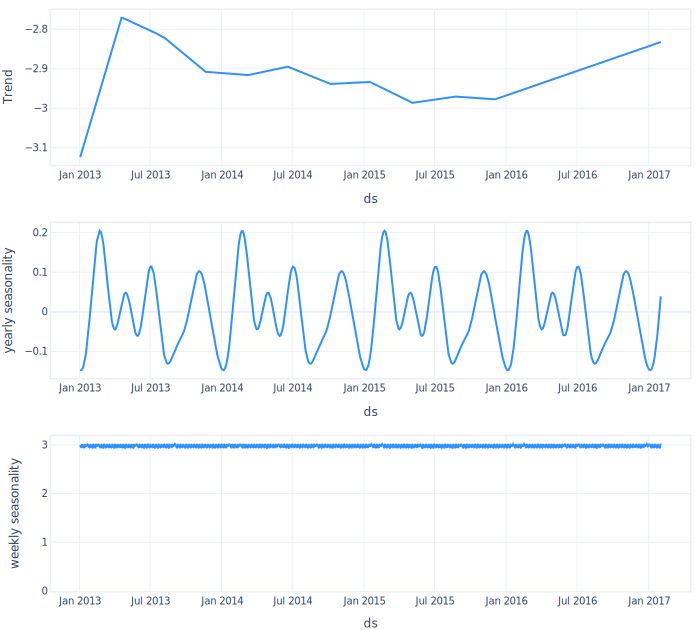

In [1240]:
# Plot components
m.plot_components(forecast);

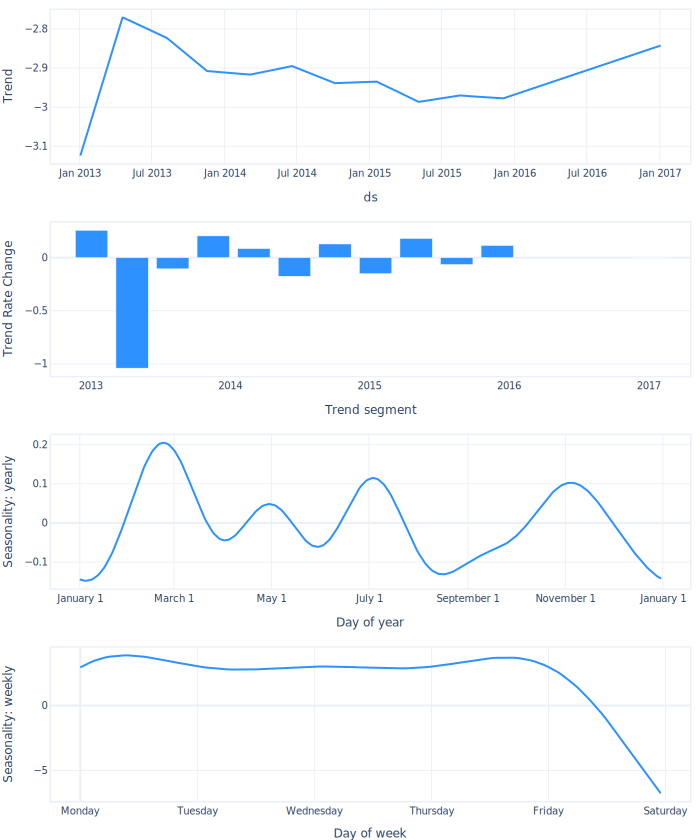

In [1241]:
m.plot_parameters()

In [1242]:
# Compute error metrics on stock returns
preds_list = forecast['yhat1'][train_val_size:train_val_size+H]
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_nprophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_nprophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_nprophet[i:i+H]['y'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 0.414133
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 225.436105
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 0.349562


In [1243]:
# Convert back to price
est_adj_close = []
prev_tg = df.loc[i-1, 'adj_close']
for n in range(H):
    est_adj_close.append((float(preds_list.iloc[n])/100+1)*prev_tg)
    prev_tg = (float(preds_list.iloc[n])/100+1)*prev_tg
    
# Compute error metrics on stock prices
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], est_adj_close)))

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 1.595414
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 1.346598
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 1.522531


(17106.0, 17225.0)

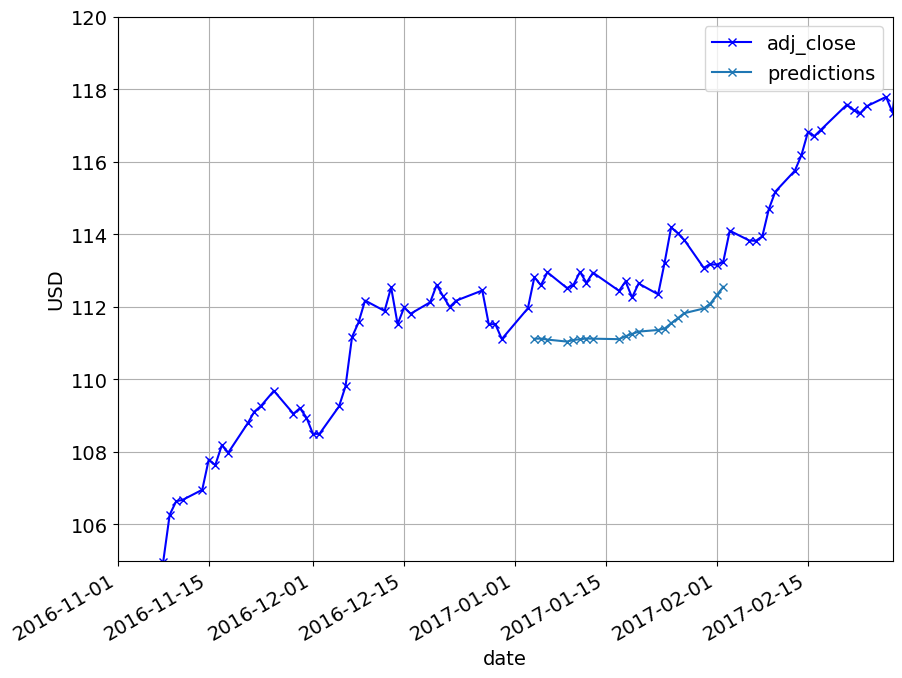

In [1244]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], est_adj_close, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - changepoint

In [1277]:
set_random_seed(random_seed) # Set a random seed for reproducibility

In [1278]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_nprophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-04 00:00:00, with forecast horizon H = 21


In [1279]:
# Get optimum hyperparams
tic = time.time()
n_changepoints_opt, results = hyperparam_tune_cp(df_nprophet[i-train_val_size:i], 
                                              df[i-train_val_size:i],
                                              H, 
                                              train_size, 
                                              val_size, 
                                              n_changepoints_list)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("n_changepoints_opt = " + str(n_changepoints_opt))

results

  0%|          | 0/5 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




n_changepoints = 2
len(inputs) =  24
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.84911544798968, 6.134074548053026, 5.595141679444889)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.270794654649467, 2.0067973678100604, 1.834697469821015)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5646930295320542, 2.250784587578647, 2.031656325601482)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.8112302123745723, 3.505821640465496, 3.368567912392241)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.2618671761511253, 2.7834214104535593, 2.743957171482924)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.343276740408042, 3.13092305633357, 3.1145918664393015)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0477612688572413, 0.9154627786912678, 0.9219528044076736)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.143994766053066, 1.6929473970530189, 1.6912395012959645)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.0913619720398158, 1.8834199775446065, 1.8754538986343063)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8722676597035424, 2.3455296953018, 2.3938593786401854)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5556084417252831, 1.0989427027272811, 1.106915923346872)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7328625145296344, 2.2953029140244117, 2.305669028179082)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.617355728297296, 2.2344518965113194, 2.307990582560889)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5438741087325427, 1.4031407243851763, 1.4859837342094342)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.5774948641146204, 0.47110899889955193, 0.5013267489589811)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.43279350869631794, 0.290967803821097, 0.31137425183825806)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.2860197193936902, 0.9355116985435791, 0.9847003849568144)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9459760938226904, 1.6735287312027218, 1.7659622030444164)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.127432166952592, 1.5429075497049929, 1.6257318986212714)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.209544647122617, 4.294369976260766, 4.488456543459207)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.394192831894223, 1.8041879971437993, 1.8787169554364258)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.826431605687149, 2.402606050012329, 2.587698095516938)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

results =  (1.8286929266517025, 1.3507410482633808, 1.4971494177969225)
Starting new day...
n_changepoints=2, fourier_order=None, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.296831304969998, 1.8993641869716562, 2.1237016966289777)
n_changepoints = 5
len(inputs) =  24
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.112262806938498, 6.4197270267743525, 5.85577697786028)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8407988100978696, 2.60118378403507, 2.374984970995065)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.746881489124576, 2.4440576933066187, 2.2362522635465827)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.862205996370851, 3.556467634310608, 3.4170635451681486)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.2755918452529347, 2.7924962876045947, 2.752966374923043)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.553624950634349, 3.31494858676715, 3.2977800552427268)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8848075563669415, 1.4865837180057977, 1.4920142894758837)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.382375379851207, 4.37793790497758, 4.377488514547695)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.8334654995824327, 3.6640403159672554, 3.6579629195352332)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.3849388024683427, 1.2156370668421865, 1.2352193240691587)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.365533016362657, 1.6913455043846422, 1.6971441773593652)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.0928753435814547, 2.670427402247417, 2.6854976592943394)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.087188207802806, 1.6671361230739739, 1.704539201622598)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.144332403799119, 0.9034152677535199, 0.9561176485280363)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2880092783116814, 1.9638540746104654, 2.092203416781131)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.920182442371959, 2.348905190479616, 2.5081673754517158)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.7750127409015548, 0.5507157416308498, 0.5838820819387874)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.432935405357253, 2.9765965405494064, 3.1467076423712967)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.84563708760076, 2.75072383126621, 2.8960765609756556)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.3612614603047, 5.253423517605063, 5.491504617151371)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.904214151429495, 1.3238301470698575, 1.3740745736020965)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.08926509625626, 3.3960967278526253, 3.666422806546591)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.1198579883844044, 0.8607550419078674, 0.9517486358391232)
Starting new day...
n_changepoints=5, fourier_order=None, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.100684209951988, 2.522053569273128, 2.820661374234996)
n_changepoints = 10
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (7.393060888861914, 7.768932494923544, 7.086614421657686)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.5831020142897723, 3.4052567500709223, 3.101336451188858)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.4961630254993046, 2.1593623118877376, 1.9594415337441593)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.538990315812308, 4.1774206581656035, 4.0138842677843165)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1226798416086434, 1.8242389909292607, 1.7978535147351244)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6158312116823128, 1.503063756235311, 1.4950204825237028)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0988090754838202, 0.8188541762613013, 0.8193982124868875)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.1080303825673905, 4.135192804297469, 4.134365592863412)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8909393920791713, 2.739033760959, 2.731429808520992)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6467004171685113, 1.428127382652569, 1.4531689326422728)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1890064130294573, 1.5644465821811049, 1.5699787193491557)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.66359804707523, 4.301749471499148, 4.34973924788588)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.3406567464730137, 2.80019505536123, 2.9083412893453597)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.7214902466229393, 0.6285572899452246, 0.6647364767441246)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0078722684001482, 0.8859490942233582, 0.9423819002968129)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.363731485977319, 1.0931242971496753, 1.1666694212880588)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.66323792450594, 2.052733625329096, 2.163635940614149)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.500561366762757, 3.8526884308469214, 4.075338362508664)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.223335907137042, 3.015263127794707, 3.1745299250333)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.594095185871386, 4.627978629635711, 4.837578301890419)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

results =  (2.9720010367182184, 2.377087384581071, 2.4844273219607493)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.8977999329347437, 3.2337957017867285, 3.4906143886666285)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.1650000508356375, 2.440619876780375, 2.7027951595230797)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.086726742415163, 3.2869991013294317, 3.6764034595462327)
n_changepoints = 15
len(inputs) =  24
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.43434725128197, 4.478577246905797, 4.084799485491073)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.9936061041848747, 2.7751258652338757, 2.5321672945886653)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7551005953881047, 2.456171968359697, 2.247831259667924)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.8086225268426865, 3.493402394360233, 3.357072648034808)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.3874880169420414, 2.894775480955911, 2.853622820284993)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5342499450236122, 1.418836589903725, 1.4110355647178927)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.0419470775950526, 1.6106253862605175, 1.6172004487687335)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.054209096094995, 3.266040903633727, 3.2647367991538183)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.937008427155788, 2.789111890218899, 2.781714184712397)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.1054597548303846, 0.9957771483572506, 1.0085584944875077)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.5375367619792306, 2.473893822649334, 2.4818897433716955)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.734678030130007, 4.370266011191118, 4.419538280408962)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.005163843567592, 2.5540448752148266, 2.646533266783737)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.141893528642616, 0.905076405037927, 0.9578566009109755)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.354287268333417, 1.1928128514119012, 1.2696784502431844)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.259350908597759, 1.8056111951722509, 1.9278371458200692)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7480919185672399, 1.2932533660524084, 1.3614518457624551)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.745754555922963, 2.3957394219923085, 2.5310437250681304)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7657938417076124, 1.9682994387451365, 2.072693106860316)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.994048165668082, 4.136613132947133, 4.3238367375990405)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.64595986659969, 2.074261676677427, 2.164771235214577)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.694905877408768, 3.873083321258853, 4.183939232043017)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6566078797757764, 1.2370493153994002, 1.3705352877165753)
Starting new day...
n_changepoints=15, fourier_order=None, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5256904753761837, 2.0785677743635245, 2.3244037964295012)
n_changepoints = 20
len(inputs) =  24
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.922426485675717, 7.28127179318227, 6.6417432542527175)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.9991976556364683, 3.8472361889252, 3.5005145888073668)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5211357572470483, 2.193866531555712, 1.9870244095372291)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.10261027805813, 3.781957036784931, 3.633596761855764)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1383899883941178, 1.8372745003814621, 1.8107207856244625)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5183832435032807, 2.374739344250246, 2.3623287736313423)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9150154193481328, 1.5116879826623055, 1.517407127808753)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.354846254165187, 4.347840786415086, 4.347276789016584)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.2839737567072085, 4.078240528244802, 4.073292808048609)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.1630321406005402, 1.0472213847257887, 1.0616075367305844)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.4908346162278407, 1.7833004282634197, 1.7894943526766507)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.729770625725666, 4.365586581469119, 4.415221619646145)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5278147406727913, 2.1541502010401623, 2.2224932325507156)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.6502064895376316, 0.5576293136863293, 0.5893248103364012)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.6190140698327307, 3.0346306797070977, 3.23450168270357)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8883455601486854, 2.3133529612433454, 2.4702003499100287)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.2425239164554265, 2.5363421556152765, 2.6746906328944196)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.1311111683327755, 2.7208539459916294, 2.8756840416867417)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.668867447732698, 1.8964687779975584, 1.9971020336897805)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.570290023030554, 5.425176891174916, 5.671089312626453)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7854141216214354, 2.197427692582963, 2.294124879422551)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.687896820449827, 2.2911670448045296, 2.4668020853117363)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.03698630694462, 1.5142487395900144, 1.6782187329306661)
Starting new day...
n_changepoints=20, fourier_order=None, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

results =  (1.804014354541726, 1.5011201076711258, 1.6779535944297514)
Time taken = 18.43944791952769 mins
n_changepoints_opt = 2


,n_changepoints_list,rmse,mape(%),mae
0,2,2.442978,2.097763,2.105937
1,5,3.058498,2.614682,2.636344
2,10,3.203476,2.755028,2.783320
3,15,2.869242,2.439042,2.466448
4,20,3.198004,2.774700,2.791351


In [ ]:
# Get predictions using tuned hyperparams
preds_list = get_preds_nprophet(df_nprophet[i-train_val_size:i], H, n_changepoints=n_changepoints_opt)

# Convert back to price
est_adj_close = []
prev_tg = df.loc[i-1, 'adj_close']
for n in range(H):
    est_adj_close.append((float(preds_list.iloc[n])/100+1)*prev_tg)
    prev_tg = (float(preds_list.iloc[n])/100+1)*prev_tg

print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], est_adj_close)))

In [ ]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], est_adj_close, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

With hyperparameter (changepoint_prior_scale) tuning, the predictions are more accurate

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - monthly seasonality

In [1096]:
set_random_seed(random_seed) # Set a random seed for reproducibility

In [1097]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_nprophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-04 00:00:00, with forecast horizon H = 21


In [1098]:
# Get optimum hyperparams
tic = time.time()
fourier_order_opt, results = hyperparam_tune_fo(df_nprophet[i-train_val_size:i],
                                                df[i-train_val_size:i],
                                                H, 
                                                train_size, 
                                                val_size, 
                                                fourier_order_list)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("fourier_order_opt = " + str(fourier_order_opt))

results

  0%|          | 0/5 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




fourier_order = 2
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.47178053955197, 6.78627922892409, 6.188627500403237)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8591086832526, 2.657655982777185, 2.424657437356872)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.335872882743461, 2.044078642126816, 1.8506543079141726)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.378508076015488, 3.9716028128862844, 3.8188391959526475)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.339509178489406, 3.829533730555003, 3.771332963952175)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.052109641596912, 1.8676827995016854, 1.8594000591820605)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5339315387505865, 1.101642669276056, 1.1060463399108404)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.447059680019295, 3.7657480492134034, 3.767349542401166)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.4716356072950747, 3.294437169212012, 3.2887075316777272)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.1463203672740832, 0.8400097809119095, 0.840601697034098)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.57542507203962, 1.7778259009818467, 1.7838645145152117)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.823093017139861, 3.4122723340899124, 3.4376094618036355)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.3063592661542986, 1.9671868570616229, 2.023733061456086)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.7305115282474004, 0.571432515622467, 0.6032628035022076)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0978320072510839, 0.9011756095882789, 0.9587992334785407)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5673280318408096, 1.2334792939479426, 1.31669002042379)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.076188723725043, 3.244177313364454, 3.4236296553925905)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5498414276530244, 2.230669989253508, 2.3576446589274673)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8994985948763303, 2.033882130820415, 2.1414813889531517)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.390538985411938, 5.132225408505042, 5.363146496888284)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.6935055533063346, 3.0364611761836273, 3.1748491901353733)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.42432482934372, 4.5218120510712145, 4.884656241366947)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.3137117157068485, 1.5535876877983312, 1.7267391791429823)
Starting new day...
n_changepoints=10, fourier_order=2, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.0285314702799835, 2.5023345917857407, 2.79835949490998)
fourier_order = 4
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.300794055482564, 5.51228636997266, 5.0264965087247)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7352073153478895, 2.5146677517758462, 2.295336300918655)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.687798269168598, 2.5032894455797834, 2.260250115866928)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.095120219657509, 3.679178806377785, 3.5391945846820905)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.1933629993582906, 1.0611915168482382, 1.0434075578194713)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1968305547183764, 1.993561908703585, 1.9847677071116612)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4084772364428928, 1.0047506832951598, 1.008750802594383)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.4156934075647065, 4.590998108931493, 4.593539968128887)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.4124100155748245, 4.145869860716158, 4.1418777842626655)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6180906225654978, 1.4120760060731117, 1.433597079179032)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2315879090516466, 1.5545142556459108, 1.5604625731092423)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.91464950001866, 4.5337674065796145, 4.581733956240585)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7420206529519615, 2.3766606656898066, 2.458277702481923)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6939576183946927, 1.3692951894484733, 1.449571014459443)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.072551646499545, 0.856107399972085, 0.9130922374062086)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8696546875382953, 2.25402108463941, 2.406709056966009)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7676285314207434, 1.3183979068576586, 1.388439011335893)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.4771723067780833, 2.165708781278942, 2.2885438028860934)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8337569138483016, 1.9970789850136446, 2.102839177224045)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.022583734389268, 4.022030418152904, 4.2025600639253735)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

results =  (2.5950212233639522, 1.9730227460832843, 2.0542776929790794)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.957745737985551, 4.162547299282401, 4.495264121690237)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6853368191771174, 1.1566036104505966, 1.284433813375557)
Starting new day...
n_changepoints=10, fourier_order=4, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.966409724100577, 4.01506017176095, 4.490460070711204)
fourier_order = 6
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.696345870150775, 7.017013425930648, 6.398863434241868)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.870737218125025, 2.667623069973967, 2.433334862659653)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.590725266942845, 2.40856863964882, 2.176794184848162)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.39574132292678, 4.016967763149609, 3.861216246701401)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.895412388072775, 2.5435797749612474, 2.5054051581342573)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2366563409434543, 1.9540900982307967, 1.9466688662578966)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.3612380525973284, 1.7112157727730786, 1.7209641841180403)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.604486199153052, 3.8475151788661286, 3.8483053451367124)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1018858678895445, 1.895592215682519, 1.88765553813087)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6849190356477988, 1.4728089791057748, 1.4946921157302158)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.1421231449903577, 2.1942135560833123, 2.202039905760192)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.547893657537486, 5.1240261063674355, 5.182906212929346)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.30468895957048, 1.9500068770759598, 2.0021924151534813)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.6740847223628089, 0.49655572547787696, 0.524027312154957)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6049335067672925, 1.2869474589853445, 1.3708194455273992)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.436973647680841, 1.9514207604793574, 2.0833986075776534)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9253696517969667, 1.428162302857091, 1.5040590577752762)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.371208677184829, 2.0601469398381527, 2.1773899794611977)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.48315060968025, 3.2564531389568336, 3.429091783605106)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.810325650297026, 5.477832993664087, 5.7243990439399965)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.492522155049874, 1.896699933817068, 1.9763854983489162)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.6819122342917683, 3.163867598051605, 3.41109514020584)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7512909062511945, 1.1090658693662585, 1.2339538053854486)
Starting new day...
n_changepoints=10, fourier_order=6, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.58736396659471, 3.7336454536179176, 4.175921805404863)
fourier_order = 8
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.460873229779004, 5.693308715064159, 5.190878185511057)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7175113935032518, 2.468544977137996, 2.2539733471053127)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

results =  (2.4744332107031903, 2.214453216030884, 2.0030695752060774)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.587284851066268, 3.2456556062631448, 3.1212068193594265)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.670326438119248, 2.3497037609397275, 2.3142665689581876)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7460671421313247, 1.5526441918389347, 1.5464550593342223)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4280891324000469, 1.0065157572008998, 1.0103790885543)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.084240551900424, 3.442752327487992, 3.443879475364315)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.4795368843926564, 2.2942933545560913, 2.2868575511958715)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.024347513738845, 1.7383100320827842, 1.767561579479687)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.108576254866532, 1.439938796493392, 1.4453833045879343)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.7358362012754975, 3.2931258492772972, 3.3162211188470243)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.218121422795204, 1.8003777604054318, 1.8416076666951906)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.9709109870067124, 0.7826196661438695, 0.8274053016733511)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.8780728653949357, 0.717557599653125, 0.7648807090438287)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0777266960326364, 0.8516390346295906, 0.9086434638424298)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.651105908271336, 1.2062497544544721, 1.269866259906203)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.22837147670831, 3.569106938431714, 3.7763642043154704)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.401515379149764, 3.2905252205568143, 3.4659648147716373)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.559728398434783, 5.283481571039572, 5.521216207095626)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.0764010351584625, 1.4253555932090287, 1.4793380410773924)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.662622042600424, 3.144676089986658, 3.390805741922405)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.155401774630925, 1.418409729974094, 1.5772872437246372)
Starting new day...
n_changepoints=10, fourier_order=8, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.474116841338439, 3.6553232518637686, 4.088382752225156)
fourier_order = 10
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.0914266362131695, 6.371606984587625, 5.809580617742089)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.510751449261919, 3.326572729397171, 3.029916247238651)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.3809681578859903, 3.351990107216908, 3.040471157865909)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.2159091880905324, 2.9013140498188874, 2.7902864655108894)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.046959708421564, 2.6970633050617034, 2.6560760247345265)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9240207178928181, 1.7433254832345906, 1.7357399554724078)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4314036948615452, 1.009743116307337, 1.0137201577135175)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.781431366596347, 4.078155273886512, 4.080624381627049)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.757043104255877, 2.568621363596937, 2.561855152947954)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.2096682670218384, 0.9322930699427936, 0.9361014604450622)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.560169407797801, 2.4384557071221393, 2.4456547483566347)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.424644079156248, 4.995358027525717, 5.052754805980293)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.511780171192758, 2.160884071895539, 2.224946399223628)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.984783448394404, 0.8472441008992183, 0.8968536034226607)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.207734243228049, 0.9657830982423043, 1.0278790719510522)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.546675083536547, 2.8520293964553476, 3.0454312652119415)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5389192734450778, 1.1125559256942448, 1.1709895482307366)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.0162118182647895, 3.411261355002256, 3.6091610167825743)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.999252842325807, 3.7631963917385054, 3.964204138543947)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.579828995007042, 4.492767123056732, 4.694575490530014)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.951861866176848, 2.325819542785439, 2.429510791446647)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.925485136133879, 3.356065958430362, 3.619767364220814)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0616547547754855, 0.7789116103951501, 0.860778775171435)
Starting new day...
n_changepoints=10, fourier_order=10, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

results =  (4.713468088690009, 3.831835295496486, 4.285817563039251)
Time taken = 8.006469980875652 mins
fourier_order_opt = 8


,fourier_order,rmse,mape(%),mae
0,2,3.146355,2.678216,2.704612
1,4,3.037244,2.590529,2.625162
2,6,3.177166,2.694334,2.719649
3,8,2.869634,2.411857,2.442162
4,10,3.223835,2.763036,2.790946


In [1099]:
# Get predictions using tuned hyperparams
preds_list = get_preds_nprophet(df_nprophet[i-train_val_size:i], H, fourier_order=fourier_order_opt)

# Convert back to price
est_adj_close = []
prev_tg = df.loc[i-1, 'adj_close']
for n in range(H):
    est_adj_close.append((float(preds_list.iloc[n])/100+1)*prev_tg)
    prev_tg = (float(preds_list.iloc[n])/100+1)*prev_tg

print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], est_adj_close)))

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 2.186154
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 1.873571
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 2.118624


(17106.0, 17225.0)

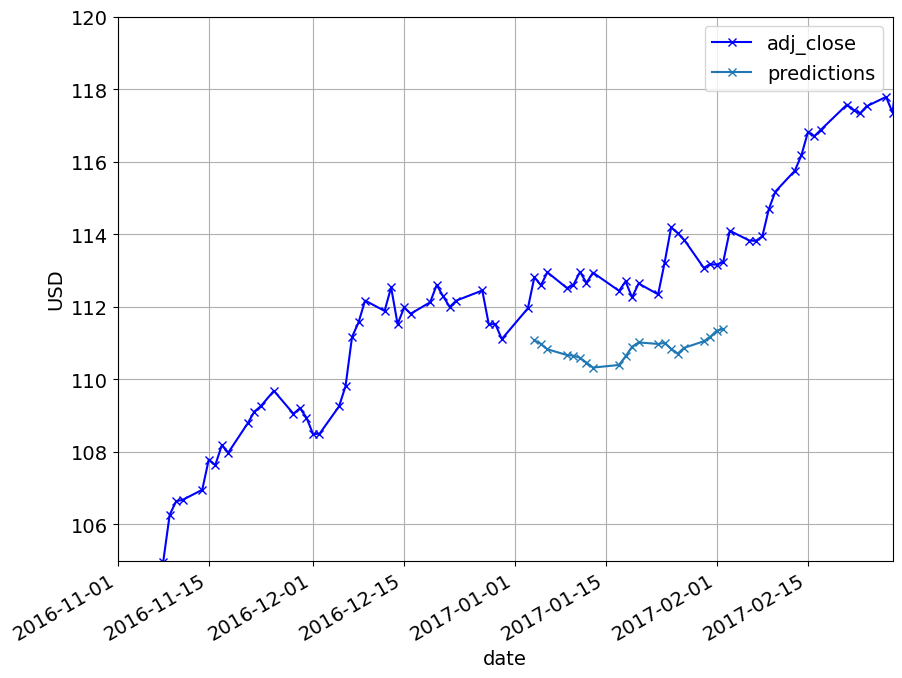

In [1100]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], est_adj_close, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - holidays

In [1101]:
set_random_seed(random_seed) # Set a random seed for reproducibility

In [1102]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_nprophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-04 00:00:00, with forecast horizon H = 21


In [1103]:
# Load holidays file
hols = pd.read_csv(holidays_path, header=None, sep="\t", names=['ds', 'event'])

# Convert Date column to datetime
hols.loc[:, 'ds'] = pd.to_datetime(hols['ds'],format='%Y-%m-%d')

hols.head()

,ds,event
0,2013-07-04 00:00:00,Independence Day
1,2013-09-02 00:00:00,Labor Day
2,2013-10-14 00:00:00,Columbus Day
3,2013-11-11 00:00:00,Veterans Day
4,2013-11-28 00:00:00,Thanksgiving Day


In [1104]:
# Convert hols into the format NProphet requires
events_df = pd.DataFrame(
    {
        "event": "hols",
        "ds": pd.to_datetime(hols['ds'])
    }
)
events_df.head()

,event,ds
0,hols,2013-07-04
1,hols,2013-09-02
2,hols,2013-10-14
3,hols,2013-11-11
4,hols,2013-11-28


In [1105]:
# Get optimum hyperparams
tic = time.time()
window_opt, results = hyperparam_tune_wd(df_nprophet[i-train_val_size:i], 
                                         df[i-train_val_size:i],
                                         H, 
                                         train_size, 
                                         val_size, 
                                         window_list,
                                         events_df)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("window_opt = " + str(window_opt))

results

  0%|          | 0/3 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.





window = 0
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.642728469643936, 6.997357387385675, 6.383605278291812)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.771412448768279, 2.5050141868992912, 2.2880188865026465)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.6215195573284773, 2.2904251956814883, 2.064624405562275)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.718412781357348, 4.3446004116016965, 4.17440521402871)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.136590419004701, 3.5690310091883095, 3.517165625026427)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.4365328181624575, 2.2983774192320587, 2.2863736049484054)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.4236847022047296, 1.9826718883092669, 1.9919015497303394)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.1890541962519654, 2.560223298920273, 2.558724327129479)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.409143222050924, 3.258769588369975, 3.252176934727881)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.0699982699625967, 1.7585170649940216, 1.7914344301213514)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.3713930307304, 3.0931377220420506, 3.1052253364238886)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

results =  (3.4278146080490557, 3.0276640483923525, 3.04854615441264)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 876, which is index 12 out of 24


WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.600674442590162, 2.222264330543199, 2.294565809367928)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.1291414354706302, 1.011991270779271, 1.0716453172784728)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.430337856969162, 1.2481605151125987, 1.3288801432924704)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.4773453795857671, 0.36585467351386985, 0.3903600312444316)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.3333970045196772, 1.795941987485176, 1.8925862184113629)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.697836769460765, 4.004468973021863, 4.236304769023109)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.0575574316174294, 2.1873749222566454, 2.3033259735670506)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.1008261068955845, 4.980696233463113, 5.205496903616701)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9223951467727727, 1.3358756398672793, 1.3867613514665877)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.155901473984988, 3.4390360336375667, 3.7132330841600494)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.965562629577207, 1.4820838574627273, 1.641942931484065)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.416389765341349, 1.9917498590208038, 2.227070746240215)

window = 1
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.42649785402316, 6.778311666744666, 6.185237121654694)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.8174882896244307, 3.5619191016485674, 3.2448519441532255)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.049830255901242, 2.863749211784238, 2.6231085017989426)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7837007667671951, 1.656450673782555, 1.5883662414230653)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.3046569761115334, 1.1542964227508674, 1.1356882970241315)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4441862622355144, 1.3216529541639372, 1.31433272076396)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.9634465460042736, 0.7295893531107981, 0.7300003405236568)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.834555894867331, 4.736972367878462, 4.736591301524912)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2960617296203534, 2.091529882567212, 2.0830709306657735)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.9965101706111232, 2.431123230215403, 2.4805316413884295)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.6916845590965117, 2.0578511250563296, 2.0706825481991253)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.386132873189777, 2.905826876026465, 2.9218503973072636)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8889290127781595, 2.4743587287881144, 2.561342232419798)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0025788050713165, 0.8918763599167987, 0.9442573380907524)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.5165961284162298, 0.35764090472754867, 0.3790255259393831)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.2274096583418201, 0.9584143479509227, 1.022277501346609)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.9793943070350113, 0.7876260935273768, 0.832402013583019)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.5862799605160114, 3.0890405312613596, 3.2660892889908877)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.1402010872503014, 3.031319066689446, 3.192716908920333)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.796630720180299, 4.621946585397603, 4.829233345114779)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.044228780548585, 2.3518046751823505, 2.4524811568671927)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.2529837460755955, 4.221409473975428, 4.5633511890637815)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.527583702768097, 1.9559936335620955, 2.1657381977139942)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-1, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.3756128522814906, 2.6915133968669886, 3.0095771056786127)

window = 2
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.857421560438154, 4.997786263183955, 4.56272695235517)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.4451992563670983, 2.1001512723012756, 1.9199579078870717)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.692447305305126, 2.3685772743396782, 2.1494927018684313)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.927016679415248, 3.6262439004175473, 3.483680762513195)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.977567372922729, 2.5594361582839413, 2.5227050699895184)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7921603922901834, 1.685204296800626, 1.6761263581522896)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5325038732507887, 2.0414623266076495, 2.051505361615092)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.599796909468874, 3.711127436668814, 3.709975720690354)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.71176461426556, 2.558483321489614, 2.5508730382417206)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7268072250948765, 2.2352588383343934, 2.278686419159937)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.078469927740507, 1.510822815933983, 1.5295396702607165)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.6063638112142242, 3.0628563574224157, 3.0786951456421665)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.630237718725509, 3.132450292888511, 3.2548674008667495)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1667262410405845, 1.6435016205041848, 1.7411693886947304)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.5411636996078083, 0.38750271470093267, 0.4107819457373213)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6842060684394202, 1.3504719026572882, 1.4407942347848197)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.714355547813078, 2.1407092835394064, 2.258111727452212)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.294773039161113, 2.834396299058662, 2.9963330311428344)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.8842553466401313, 2.89211853183662, 3.046828879339631)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.675896626293668, 5.083121407701903, 5.308183720194525)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.3594479957025865, 4.4424816116367865, 4.651096943515639)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.822074982632646, 4.629446734905824, 5.0057306544143065)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5878550205389828, 1.2065656459035452, 1.3360800960214063)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=-2, n_lags=None
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

results =  (1.8307719641561258, 1.4976362591643841, 1.6728705323732425)
Time taken = 4.769011382261912 mins
window_opt = 1


,window,rmse,mape(%),mae
0,0,3.104402,2.656304,2.673099
1,1,2.930549,2.488426,2.513867
2,2,3.172470,2.654076,2.693201


In [1106]:
# Get predictions using tuned hyperparams
if window_opt is None:
    preds_list = get_preds_nprophet(df_nprophet[i-train_val_size:i], H, holidays=None)
else:
    preds_list = get_preds_nprophet(df_nprophet[i-train_val_size:i], H, 
                                    holidays=events_df, lower_window=-window_opt, upper_window=window_opt)
    
# Convert back to price
est_adj_close = []
prev_tg = df.loc[i-1, 'adj_close']
for n in range(H):
    est_adj_close.append((float(preds_list.iloc[n])/100+1)*prev_tg)
    prev_tg = (float(preds_list.iloc[n])/100+1)*prev_tg

print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], est_adj_close)))    

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 32it [00:00, ?it/s]

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 2.051914
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 1.737586
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 1.964927


(17106.0, 17225.0)

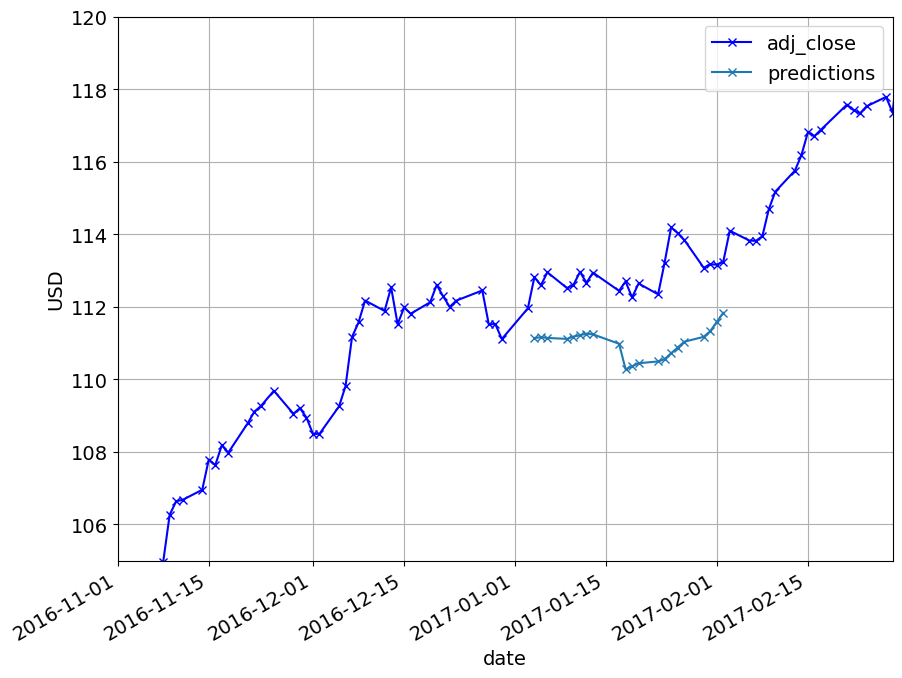

In [1107]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], est_adj_close, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - autoregression n_lags

In [1108]:
set_random_seed(random_seed) # Set a random seed for reproducibility

In [1109]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_nprophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-04 00:00:00, with forecast horizon H = 21


In [1110]:
# Get optimum hyperparams
tic = time.time()
n_lags_opt, results = hyperparam_tune_nl(df_nprophet[i-train_val_size:i],
                                         df[i-train_val_size:i],
                                         H, 
                                         train_size, 
                                         val_size, 
                                         n_lags_list)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("n_lags_opt = " + str(n_lags_opt))

results

  0%|          | 0/4 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




n_lags = 0
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.8633839596205055, 7.218978259908878, 6.58487175388665)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.257791804640882, 3.064273371258975, 2.7933299988212963)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.608932575835716, 2.328315746329872, 2.101129247728752)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.398475234572296, 4.046077371185999, 3.8877406471979503)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4514395954418111, 1.2713248821020666, 1.2515066410604543)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.6928287090107386, 2.5388227190167294, 2.5255018202886195)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6023820028266544, 1.2315250584747703, 1.2348250457141197)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.700427804950981, 3.8112012120098777, 3.810347768079579)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.3759657734102975, 4.1692037602320795, 4.163988139080162)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2963592660287047, 1.925843081522409, 1.9635696421205833)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7531696200930231, 1.242500186060593, 1.2482607078637236)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.536462084706562, 3.173640150506518, 3.198833916952652)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.772303028856611, 2.3649630597897056, 2.44585935254589)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.582958533289724, 1.224346743916909, 1.2965464757891514)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5470727465553016, 1.3560356460065148, 1.4437912368132306)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5923311735249719, 1.275138101436206, 1.3611454842400088)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2097985048867215, 1.6796131201201172, 1.7694806978938598)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.363030659703992, 3.751099008259204, 3.9675277521455543)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.6257459449191694, 2.587509380515282, 2.724222019462291)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.326355359846968, 4.404209353511333, 4.603550971420109)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8633307741221365, 1.288518772262936, 1.337512526036385)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.008892414811279, 2.5452663862617735, 2.742747348949657)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1192177897290834, 1.601444171879272, 1.7741668077542319)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=0
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7501407909177464, 2.2506260577155865, 2.516879808270537)
n_lags = 2
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.608223553341666, 5.848632404867795, 5.338237146572413)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5955451189083014, 2.253775968137329, 2.0512757443627496)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.634154682455011, 4.144804630742412, 3.8482904307685946)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.914641322037808, 6.889917801145323, 6.585223051806981)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8025372762377314, 1.6893445367125872, 1.6541845897504532)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7309355964919038, 1.4025831683523418, 1.391950792479601)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.89266220404802, 1.7463094054804311, 1.7495438477173946)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5683233775537062, 1.2103957131431045, 1.208680101592132)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7994411369005725, 1.687185851584902, 1.68520611862451)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.076240427220499, 0.9755468650723801, 0.9880242108967516)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.030562092339282, 1.4261942000874388, 1.429887124683446)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6712722359928653, 1.3134222186574385, 1.3187594181939306)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2056158638639882, 1.837920305886747, 1.8895805579168095)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0407629391915605, 0.8744693524337438, 0.9246676593505179)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.524204300123059, 2.16945969565794, 2.3115460058183634)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8894243760414684, 1.5418871997679964, 1.6461611900522968)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.37833681236793, 1.8514262499712912, 1.9515030068452974)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.366100396701207, 1.0471209228818117, 1.1021418422976004)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.9238339970807885, 0.7748560077828477, 0.8203865487655115)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.3115058588020863, 1.8655484927103432, 1.9482029778521925)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.3665675491203761, 1.0941391839963701, 1.1507468067469877)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.403335210221302, 2.079900823558677, 2.2370620155000616)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.2896145907626695, 1.0137142887368893, 1.1196076155083128)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=2
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.9719279969110203, 0.7286490998364428, 0.8111433944576089)
n_lags = 5
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.42860828153879, 5.638316499051307, 5.14179535436194)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.0031786098019517, 2.619860047714052, 2.3934980319317654)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.6391879092842943, 3.3337456085438943, 3.0841689886915313)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (9.629774013453673, 9.52998004355192, 9.115067843743859)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7364125875142267, 1.6005431714901417, 1.5705718359321572)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.2256049885735, 1.0154143916812932, 1.0059372484013043)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.509399545853629, 2.3201956909590105, 2.3278392078829313)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.0805598286263933, 1.6815181993606412, 1.6813128709973537)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.334831094181578, 2.2494082515669955, 2.2450150357629393)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.8819446409781839, 0.7700413719636188, 0.7757621424241515)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7140460147342682, 1.214342104606309, 1.2182850481468155)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.856119522961085, 2.414528440778692, 2.4256863705208604)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.652802046226272, 1.0074642607604787, 1.016037351320648)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0020897491277738, 0.8299634147990151, 0.8767517030068231)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.1391923885343653, 0.8009215605248485, 0.8534119177955715)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2724097306828552, 1.9162221485073867, 2.045884939721767)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2802920611264894, 1.6792526242681376, 1.7683062346745557)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5143020528414493, 2.2192010700169935, 2.34291853295772)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.839722025506044, 0.6620329649774147, 0.7009713630367558)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6575203486904202, 1.2854064375527865, 1.341376317995074)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6824007670179526, 1.4524074707321069, 1.5283338931801507)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.1532580179565874, 2.693145365092017, 2.9028734212226803)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.701938865699962, 3.7298172432955274, 4.126321219733373)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=5
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8456013984867656, 2.1024897225384738, 2.3509625280047777)
n_lags = 10
len(inputs) =  24
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.927587938868216, 6.0989910703805945, 5.564887436026244)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.6901655228741648, 2.322295550653187, 2.124285927620556)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.136372243877865, 3.7808571884684796, 3.5072295872757335)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.389044895623105, 5.075361688988378, 4.8712548142669)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.4150108045376952, 2.23490862562911, 2.194748752740005)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.138375904005838, 0.958999535536195, 0.9493518844519455)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7426894286907555, 1.5770619477734023, 1.5802566542190826)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0845154425675674, 0.8542462411159019, 0.8533857369099997)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.106395149793455, 1.9915736678975622, 1.9859473716390528)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.8641544801462266, 0.7809795667807151, 0.7879353921187524)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.3373901481112727, 1.7011224155279054, 1.7074505112672778)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.048525449841566, 2.6331224273481073, 2.647732732506122)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2269251377757024, 1.8646610666331935, 1.9191024577500204)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.1964535548808852, 1.0387138492524133, 1.0981879701006345)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.37535381020465, 1.0546341611743546, 1.1236640652040624)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5748306377528956, 1.3759769589789763, 1.4687928258990122)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.0678359306705842, 1.4565263744962484, 1.5324397611338365)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.530542775864484, 2.2315411552065023, 2.3559037449593387)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0149843422700118, 0.797285381196359, 0.8421733303867495)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4635578454061606, 1.1244511020461225, 1.1732436644554405)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9996591920250337, 1.6390089551549838, 1.7329945627551977)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.545434548779617, 2.1490406279468925, 2.3139422088923127)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.9341055674276917, 3.128706692675028, 3.4613084014661064)
Starting new day...
n_changepoints=10, fourier_order=None, lower_window=0, n_lags=10
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

results =  (3.86751257672387, 2.9805235826633325, 3.3348413285350667)
Time taken = 6.616959071159362 mins
n_lags_opt = 2


,n_lags,rmse,mape(%),mae
0,0,3.012450,2.597936,2.614472
1,2,2.249824,1.977800,1.965084
2,5,2.615883,2.281926,2.284962
3,10,2.444893,2.118775,2.130461


In [1111]:
# Get predictions using tuned hyperparams
preds_list = get_preds_nprophet(df_nprophet[i-train_val_size:i], H, n_lags=n_lags_opt)

# Convert back to price
est_adj_close = []
prev_tg = df.loc[i-1, 'adj_close']
for n in range(H):
    est_adj_close.append((float(preds_list.iloc[n])/100+1)*prev_tg)
    prev_tg = (float(preds_list.iloc[n])/100+1)*prev_tg

print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], est_adj_close)))

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 1.178283
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 0.890123
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 1.005321


(17106.0, 17225.0)

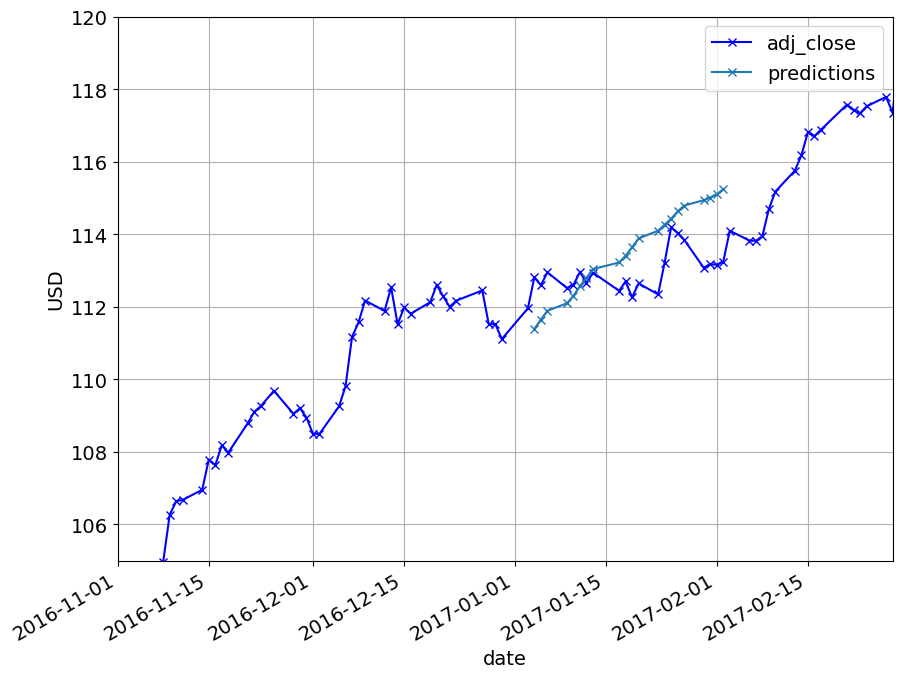

In [1112]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], est_adj_close, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - changepoint, monthly seasonality, holidays, n_lags

In [1203]:
set_random_seed(random_seed) # Set a random seed for reproducibility

In [1204]:
n_changepoints_list = [2, 5]     # for hyperparameter tuning
fourier_order_list = [6, 8]                 # for hyperparameter tuning
window_list = [1]         # Event parameters. For hyperparameter tuning
n_lags_list = [0, 2] 
holidays_list = [None, events_df]

In [1205]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_nprophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2017-01-04 00:00:00, with forecast horizon H = 21


In [1213]:
# Get optimum hyperparams
tic = time.time()
n_changepoints_opt, fourier_order_opt, window_opt, n_lags_opt, holidays_opt, results = \
    hyperparam_tune_cp_fo_wd_nl(df_nprophet[i-train_val_size:i], 
                                df[i-train_val_size:i],
                                H, 
                                train_size, 
                                val_size, 
                                n_changepoints_list,
                                fourier_order_list,
                                window_list,
                                [events_df],
                                n_lags_list)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("n_changepoints_opt = " + str(n_changepoints_opt))
print("fourier_order_opt = " + str(fourier_order_opt))
print("window_opt = " + str(window_opt))
print("n_lags_opt = " + str(n_lags_opt))
print("holidays_opt = " + str(holidays_opt))
results

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

len(inputs) =  24
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 756, which is index 0 out of 24


WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.428125996002734, 5.66377969239939, 5.165357445223329)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.164046839415553, 1.889515246813756, 1.72751407310041)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.551777565176835, 2.2115535427723576, 2.0045781365878783)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.432064844541039, 4.049976768389377, 3.892942690668632)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.1727413930849075, 2.807604424059639, 2.7648276120104307)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.1781634362755122, 2.8192574246281272, 2.8070902012419587)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5381025603435998, 1.2758624410039796, 1.2877173759479956)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.9599042411703143, 2.4434990834456487, 2.44293596719688)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1632459617125255, 1.9530591657702145, 1.9449115767001488)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.84105795473687, 2.3542507503906602, 2.3982344893406045)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.965023756251035, 1.6415378110755676, 1.6654469727129289)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.4356914027051872, 2.946475894085504, 2.963266458950962)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.6048518502659173, 3.0862832661515087, 3.20733880641802)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4669744107818536, 1.3127852496726964, 1.390324923412421)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.8030408633276866, 0.6431415837941622, 0.6855614883607378)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.6464411569231455, 0.5214228218344223, 0.5566542309704591)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.8144930915036633, 0.5300750491216372, 0.5645101815640973)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2700984916344895, 1.9799839905030672, 2.0923078004212448)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7102422506648127, 1.232725535188638, 1.2991855951322293)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.589083377102034, 3.592984528745049, 3.7531065097722727)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.683003855207436, 2.001013374966707, 2.0827857986850464)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.894391225363336, 2.481028857704512, 2.6712158966035093)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.718371387700541, 1.0933055794483786, 1.2165228205619396)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=0
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8257546145016517, 2.342871524596704, 2.6194817061411095)
len(inputs) =  24
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.987134903777719, 6.288338515462579, 5.735762200158458)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.522758781255203, 2.08424112217036, 1.9042337820557529)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.748287458539064, 3.5153357310588738, 3.2512443639989086)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.388953396831632, 6.09269066955509, 5.843699082397241)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.548375165303051, 2.4226850978535364, 2.3769542921020763)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.264432169846669, 1.0516810920893693, 1.0412503799195374)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.2678701706896882, 1.0066122788271565, 1.0054304322490784)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7475234135297302, 1.4282006850282838, 1.427621744314143)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4552101897785017, 1.2779452148190416, 1.2722313803157137)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.2478101520582026, 1.065044349241793, 1.0841765786464694)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6998091223616, 1.4976412806573571, 1.5225924877836257)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.4159804282947537, 1.933059713865853, 1.9405867203750518)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7356561593150834, 2.3394222954318247, 2.4180489733509773)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.365917781869776, 1.0862664114747493, 1.1475345602648723)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9229493337408756, 1.7392575870629072, 1.851088213190639)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.657656058177944, 0.4619160384561301, 0.4926170629048719)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.8856307015544277, 0.7133203717987531, 0.7534692459134126)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.632888086142667, 1.3878499221587146, 1.464242232502143)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.6114948461888478, 0.4922539615889827, 0.5216731146756116)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5464337746371934, 1.1072570765503866, 1.1543949831892322)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4412816013359413, 1.1285888417319856, 1.178316077223165)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.9732463392078365, 2.4885036509328455, 2.6815748061596465)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.782799219826035, 1.444108659617844, 1.592800157153555)
Starting new day...
n_changepoints=2, fourier_order=6, lower_window=1, n_lags=2
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

results =  (1.1227751463103475, 0.8993317310971953, 1.003871330444197)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




len(inputs) =  24
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.592220766570255, 5.8392957044157905, 5.324724104583889)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.21122595615222, 1.9169301331807969, 1.7528902982248127)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.558056174530184, 2.2378151026627586, 2.0255367146227687)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.542584677167784, 4.118464639515339, 3.9601347538065617)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.3558436690627067, 2.979198127086917, 2.9334737698710596)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.5056956411830864, 3.1487542460802174, 3.134486383467212)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.25793272281572, 1.0512480892622296, 1.0602908409846452)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.519058408725448, 2.077935071434146, 2.07734647755486)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.0225329061699204, 1.804791393566781, 1.7969753689416936)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.754573051693412, 2.2664281732701865, 2.308940728881607)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9642934789508315, 1.6605488584889825, 1.685293622127467)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.4511872159545316, 2.958551854578641, 2.975125154534107)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.497378786712645, 2.9802620073587995, 3.095054475510078)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4710431915498765, 1.2914417685210278, 1.367884841596522)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.7568911373336952, 0.6211322417788333, 0.6616344921524951)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.7246969935584842, 0.5753626612628222, 0.6142338541975045)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.7903331500966784, 0.5629847205883319, 0.5985382514920222)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1214801600460595, 1.83657155255333, 1.940535399353286)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2814270389257927, 1.674133632891733, 1.7636892342036634)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.4613406188546305, 3.49192307662611, 3.6474358877144173)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.6561914739223638, 1.9796932338577218, 2.0614374799705466)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.807825763975017, 2.406821508276706, 2.590941200146216)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.6587599130267674, 1.0591176264679711, 1.1781234538005398)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=0
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.707511658935605, 2.2516261746796236, 2.517414442290432)
len(inputs) =  24
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.0588209721477995, 6.3700266557911736, 5.810832823172658)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.121309136783317, 2.5769301132192752, 2.352511748122364)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.736489971135176, 3.4949163065804325, 3.2340609354249135)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.311351271978061, 6.028330187025109, 5.781438583621717)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.862041107510199, 2.656587851155274, 2.6089201951500307)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.2641301127916749, 1.0207689668751305, 1.0106088774646345)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.2288274290052763, 0.9687644552570034, 0.9666231480450482)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5297393438582283, 1.253555836657997, 1.253127001575073)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.3652661410652343, 1.2030102261791908, 1.1978963739645454)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5717283896043843, 1.2684382430801449, 1.2949815275609469)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5230852420789978, 0.9871165731215801, 0.99028908210035)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5515265699360117, 2.0459399336334316, 2.0530232124578895)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.6475568705592734, 2.2667596394861156, 2.338693461111227)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.3118545150605856, 1.0851879620036018, 1.1466009214425)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1889981664025386, 1.9577089329836987, 2.0842388429633028)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.6593150684621709, 0.4695451677380485, 0.5007295228002461)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9428921839676387, 1.568849554218254, 1.6545756602681636)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8394349238763894, 1.5857201868512718, 1.6737559659194985)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.7121305409149135, 0.5355636523528778, 0.5655796336060896)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0986089156414935, 0.7360087739163722, 0.7667911670039729)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5153896395169084, 1.09689616107607, 1.1416388470633376)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.890331207472081, 2.4234503380972194, 2.6103237834373196)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.667184128261448, 1.3490496162941443, 1.4872803428894505)
Starting new day...
n_changepoints=2, fourier_order=8, lower_window=1, n_lags=2
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

results =  (1.0620212436862795, 0.8109314458084884, 0.9044252203818279)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




len(inputs) =  24
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.116653804712861, 6.415839903010842, 5.851374707356982)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8419605314315546, 2.587997150163476, 2.362746126437213)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7721409708772553, 2.4808636346326898, 2.271105907570936)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.061427737401184, 4.612936520142908, 4.434537284583377)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.121779609858372, 1.8696319957146008, 1.8412404114673724)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8692148640666946, 2.5398437400479708, 2.5291610291970956)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.0573044610593934, 0.815309604128788, 0.8184982170942549)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.162780736554761, 2.618154298416684, 2.6177613578121037)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.0972647458761124, 2.9216948231004793, 2.9143533452034083)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.0804693807438928, 1.78306505327273, 1.811847119557294)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9642999641285757, 1.4027151478147992, 1.416545595513389)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.830789999655031, 4.399514970304363, 4.4405915113720855)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5851166930284064, 2.2466471258757665, 2.3166241352288575)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.7706395172009848, 1.413765771432062, 1.496860691575309)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9162093520625894, 1.57420355149628, 1.6770194306673303)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.8170241260937297, 3.0736537614175607, 3.2819493444637375)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.599673237066897, 2.010304704785327, 2.119819741826995)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.0479040802022075, 3.4410732210793458, 3.640625901010393)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.6790298319151393, 1.948328795381648, 2.0521954321527764)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.371680542051797, 4.247242704963485, 4.437387846893907)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.533450348701065, 1.842133904437599, 1.9155063602121731)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.6055420666945084, 3.0519420326380007, 3.2907246398471592)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8589747556028013, 1.178459873838307, 1.3115190524884734)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=0
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.530141094669444, 3.682474854477281, 4.118124922423653)
len(inputs) =  24
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.976794363464289, 6.282873033614608, 5.731011566472314)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7143792056544225, 2.2948190066017347, 2.094839680381542)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.300063657706595, 4.850843503056969, 4.504013780384669)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.123855708339707, 5.841926527512607, 5.603108483028255)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.273766761548163, 2.144558012624202, 2.1033670188568925)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9447706938627165, 1.6988290638952401, 1.6856953930024487)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1808822624412967, 1.8018019234121465, 1.8081618324059041)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.346083995931276, 1.9361701542208853, 1.9357882283145669)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8522879113690658, 1.7629573802121854, 1.7582567721153541)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.8331404491312174, 0.775549554249872, 0.7857369902101707)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2212002063680396, 1.4601950012248268, 1.4613492937761792)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.0469466846369335, 2.5646701813955333, 2.578647938414678)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.3824573193956717, 2.0154258291550082, 2.0732273430948744)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.3876700303821239, 1.1934877131860568, 1.2623885455651305)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.881626741351816, 1.4809604169056527, 1.5776606130322004)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5142041038605567, 1.1462296654198627, 1.22347562616381)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.474408943440345, 2.021276797887337, 2.13250837769806)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.4952488924040974, 2.1752286005401418, 2.29831844861233)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.7068672361975793, 0.5303429743031156, 0.5600127952837093)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.3476308189304802, 0.9283418567650726, 0.9673750217912813)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5223335767955157, 1.2330354722872174, 1.2949039746093054)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.52921727802784, 2.937262428980716, 3.169297255354736)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8921307392879978, 1.5508114415150729, 1.7104731576367211)
Starting new day...
n_changepoints=5, fourier_order=6, lower_window=1, n_lags=2
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

results =  (1.1540343138429012, 0.9270893446839025, 1.0354375685006592)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




len(inputs) =  24
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.751416331796722, 4.872225197666077, 4.442632539446707)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7560000912506566, 2.4818354115466197, 2.2666512566357038)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.039553182533898, 2.818214148850642, 2.589574889352977)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.8452899107449046, 3.501971435272088, 3.366688768174649)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.965034990804659, 3.5208373086549116, 3.4666713995121947)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.038746028425938, 3.6150400263791695, 3.5984792071017004)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8597955264177943, 1.3544960283020056, 1.3611775439146403)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.671921354271919, 2.224242579915085, 2.224015876533209)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7782918310262024, 2.589553312761274, 2.5827613038611226)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8132796395516608, 1.5523446170144997, 1.5750719483226305)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.8678165607067265, 1.4750969670356315, 1.4948563376316173)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (3.196983327641889, 2.7458274555918205, 2.762077142391918)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.9332152721930282, 2.556141320064416, 2.643630787622132)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.648295576144687, 0.5139672118310167, 0.5431308947409432)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.6200178547345376, 2.1523355838539997, 2.293646958286507)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.780674951180065, 1.4138142914696088, 1.5087865885006333)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.52197910516554, 1.1745178398639562, 1.2383757650499783)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.439938104116757, 3.7250471636602978, 3.9419240020199724)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9592964561059134, 1.426299857876762, 1.50272639008187)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.270211598173429, 3.326845531720331, 3.4747359050974675)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.1583247274312733, 1.498267820531972, 1.5556975660510808)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.171937270438075, 3.494313467730797, 3.771270294167002)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.0900668350797384, 1.3314680345232284, 1.4816261010882332)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=0
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 24it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (4.461964095273399, 3.633497793986239, 4.063424947928486)
len(inputs) =  24
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 756, which is index 0 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.2497283696391985, 6.574170402350853, 5.996973522592471)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 766, which is index 1 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.8486025838194444, 2.4404674848571553, 2.2259068924622314)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 776, which is index 2 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.3514378333641455, 5.881421143363505, 5.455622426948777)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 786, which is index 3 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (6.804348666822392, 6.4542671163534555, 6.192145628478765)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 796, which is index 4 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.7485518533880007, 2.59520202240971, 2.547391230518386)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 806, which is index 5 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.1019838515292915, 0.8545376273559604, 0.8450967343852559)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 816, which is index 6 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.4154901386787957, 1.1410588563517687, 1.1400343226951042)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 826, which is index 7 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.403043986187347, 1.9892002647222213, 1.9888356545178025)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 836, which is index 8 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5679440857439455, 1.423576916070281, 1.4180036396411064)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 846, which is index 9 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.7805771299586881, 0.7237716507604913, 0.733099702085391)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 856, which is index 10 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.2548209712365326, 1.4918706980929346, 1.4935827482662103)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 866, which is index 11 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.67199051868777, 2.15641636276957, 2.1640809994913304)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 876, which is index 12 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.9248488761975557, 2.506635860816008, 2.59283622028862)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 886, which is index 13 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.3645989032031733, 1.1726782055671756, 1.2397489147059193)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 896, which is index 14 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5292589433135895, 2.2458066735318214, 2.3916961940197736)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 906, which is index 15 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.5854904160518914, 1.2421332266926457, 1.3258832100898092)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 916, which is index 16 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.5208726820670577, 2.0781183122351243, 2.1929171798347675)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 926, which is index 17 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (2.262307107378568, 1.970184968247053, 2.0812627544976667)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 936, which is index 18 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (0.6328552630814738, 0.47660643164407, 0.5038515580168391)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 946, which is index 19 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.3509093019900364, 0.9286885354660925, 0.9676878144590011)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 956, which is index 20 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.469792949108401, 1.1258444466651811, 1.174917677285369)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 966, which is index 21 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (5.488994356313104, 4.499263596707329, 4.865813713770468)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 976, which is index 22 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




results =  (1.9115433627736305, 1.5904004126527667, 1.7532546696888607)
Starting new day...
n_changepoints=5, fourier_order=8, lower_window=1, n_lags=2
day = 986, which is index 23 out of 24


Finding best initial lr:   0%|          | 0/223 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 25it [00:00, ?it/s]

results =  (1.1305833448141045, 0.9047393727609602, 1.010212555913061)
Time taken = 35.72452239990234 mins
n_changepoints_opt = 2
fourier_order_opt = 6
window_opt = 1
n_lags_opt = 2
holidays_opt =    event         ds  lower_window  upper_window
0   hols 2013-07-04            -1             1
1   hols 2013-09-02            -1             1
2   hols 2013-10-14            -1             1
3   hols 2013-11-11            -1             1
4   hols 2013-11-28            -1             1
5   hols 2013-12-25            -1             1
6   hols 2014-01-01            -1             1
7   hols 2014-01-20            -1             1
8   hols 2014-02-17            -1             1
9   hols 2014-05-26            -1             1
10  hols 2014-07-04            -1             1
11  hols 2014-09-01            -1             1
12  hols 2014-10-13            -1             1
13  hols 2014-11-11            -1             1
14  hols 2014-11-27            -1             1
15  hols 2014-12-25            -1  

,n_changepoints,fourier_order,window,n_lags,holidays,rmse,mape(%),mae
0,2,6,1,0,event ds lower_window upper_windo...,2.577362,2.203083,2.216826
1,2,6,1,2,event ds lower_window upper_windo...,2.123870,1.872981,1.861059
2,2,8,1,0,event ds lower_window upper_windo...,2.569587,2.199626,2.211339
3,2,8,1,2,event ds lower_window upper_windo...,2.194168,1.906669,1.892873
4,5,6,1,0,event ds lower_window upper_windo...,3.137145,2.673242,2.707005
5,5,6,1,2,event ds lower_window upper_windo...,2.462583,2.148112,2.139794
6,5,8,1,0,event ds lower_window upper_windo...,2.901669,2.458258,2.489568
7,5,8,1,2,event ds lower_window upper_windo...,2.598774,2.269461,2.262536


In [1214]:
# Get predictions using tuned hyperparams
preds_list = get_preds_nprophet(df_nprophet[i-train_val_size:i], 
                               H, 
                               n_changepoints_opt, 
                               fourier_order_opt, 
                               holidays=events_df,
                               lower_window=window_opt,
                               upper_window=window_opt,
                               n_lags=n_lags_opt)

# Convert back to price
est_adj_close = []
prev_tg = df.loc[i-1, 'adj_close']
for n in range(H):
    est_adj_close.append((float(preds_list.iloc[n])/100+1)*prev_tg)
    prev_tg = (float(preds_list.iloc[n])/100+1)*prev_tg

print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], est_adj_close)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], est_adj_close)))

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the RMSE is 1.043535
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAPE is 0.810040
For forecast horizon 21, predicting on day 1008, date 2017-01-03 00:00:00, the mean MAE is 0.913993


(17106.0, 17225.0)

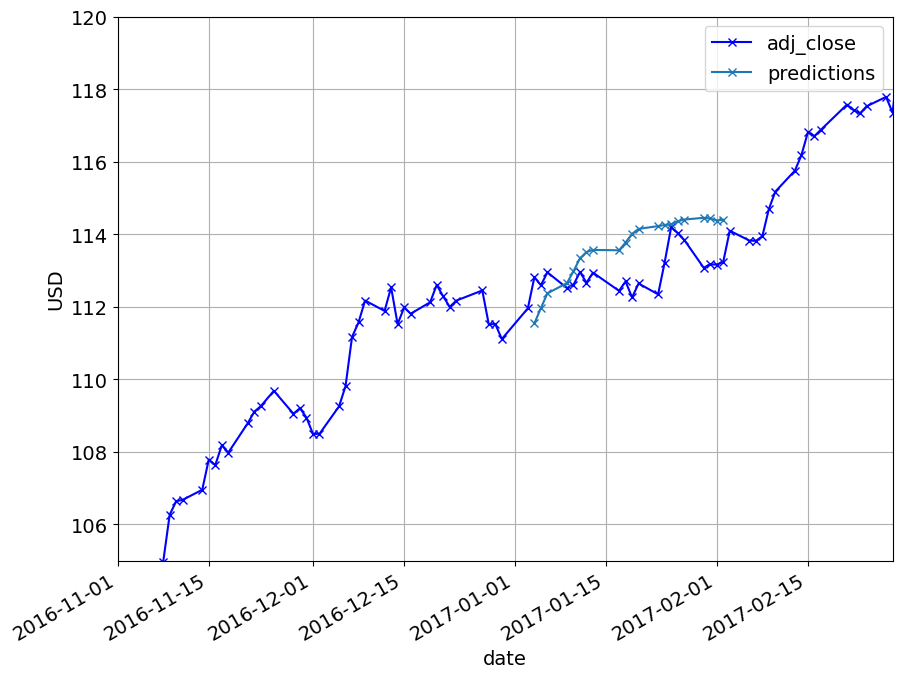

In [1215]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], est_adj_close, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon), and various dates, using model trained in previous step

In [957]:
n_changepoints_opt = 2
fourier_order_opt = 6
window_opt = 1
n_lags_opt = 2

In [1250]:
# Predict using Prophet, and compute error metrics also
rmse = [] # root mean square error
mape = [] # mean absolute percentage error
mae = []  # mean absolute error
preds_dict = {}
H = 21 # We will test with this value of H and observe the results
i_list = range(train_val_size, train_val_size+84*5+42+1, 42)
for i in i_list:
# for i in tqdm_notebook(range(train_val_size, len(df)-H, int(H/2))): # Do a forecast on day i
    print("Predicting on day %d, date %s" % (i, df_nprophet['ds'][i]))
    
#     # Get predictions using tuned hyperparams
#     if (window_opt is None) or (np.isnan(window_opt)):
#         preds_list = get_preds_prophet(df_nprophet[i-train_val_size:i], 
#                                        H, 
#                                        changepoint_prior_scale_opt, 
#                                        fourier_order_opt, 
#                                        holidays=None)
#     else:
#         hols['lower_window'] = -window_opt
#         hols['upper_window'] = +window_opt
#         preds_list = get_preds_prophet(df_nprophet[i-train_val_size:i], 
#                                        H, 
#                                        changepoint_prior_scale_opt, 
#                                        fourier_order_opt, 
#                                        holidays=hols)
    
    preds_list = get_preds_nprophet(df_nprophet[i-train_val_size:i], 
                                    H, 
                                   n_changepoints_opt, 
                                   fourier_order_opt, 
                                   holidays=events_df,
                                   lower_window=window_opt,
                                   upper_window=window_opt,
                                   n_lags=n_lags_opt)
    
    
    
    # Convert back to price
    est_adj_close = []
    prev_tg = df.loc[i-1, 'adj_close']
    for n in range(H):
        est_adj_close.append((float(preds_list.iloc[n])/100+1)*prev_tg)
        prev_tg = (float(preds_list.iloc[n])/100+1)*prev_tg
        
    # Collect the predictions
    preds_dict[i] = est_adj_close
    
    # Compute error metrics
    rmse.append(get_rmse(df[i:i+H]['adj_close'], est_adj_close))
    mape.append(get_mape(df[i:i+H]['adj_close'], est_adj_close))
    mae.append(get_mae(df[i:i+H]['adj_close'], est_adj_close))

print("Altogether we made %d forecasts, each of length %d days" % (len(rmse), H))

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1008, date 2017-01-03 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1050, date 2017-03-06 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1092, date 2017-05-04 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1134, date 2017-07-05 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1176, date 2017-09-01 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1218, date 2017-11-01 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1260, date 2018-01-03 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1302, date 2018-03-06 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Predicting on day 1344, date 2018-05-04 00:00:00


WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1386, date 2018-07-05 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1428, date 2018-09-04 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Predicting on day 1470, date 2018-11-01 00:00:00


Finding best initial lr:   0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 33it [00:00, ?it/s]

Altogether we made 12 forecasts, each of length 21 days


In [1249]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

For forecast horizon 21, the mean RMSE is 2.154246
For forecast horizon 21, the mean MAPE is 1.406205
For forecast horizon 21, the mean MAE is 1.883749


In [1251]:
results_final_no_tune = pd.DataFrame({'day': i_list,
                                      'n_changepoints_opt': [n_changepoints_opt]*len(i_list),
                                      'fourier_order_opt': [fourier_order_opt]*len(i_list),
                                      'window_opt': [window_opt]*len(i_list),
                                      'n_lags_opt': [n_lags_opt]*len(i_list),
                                      'rmse': rmse,
                                      'mape': mape,
                                      'mae': mae})
results_final_no_tune

,day,n_changepoints_opt,fourier_order_opt,window_opt,n_lags_opt,rmse,mape,mae
0,1008,2,6,1,2,1.544378,1.133238,1.279563
1,1050,2,6,1,2,2.117840,1.613772,1.887523
2,1092,2,6,1,2,0.972081,0.581404,0.691804
3,1134,2,6,1,2,1.067390,0.760891,0.936643
4,1176,2,6,1,2,1.319756,0.810497,1.017334
5,1218,2,6,1,2,0.959868,0.594564,0.776688
6,1260,2,6,1,2,2.158455,1.409132,1.989534
7,1302,2,6,1,2,4.906231,2.913381,3.895615
8,1344,2,6,1,2,4.624024,3.244003,4.495303
9,1386,2,6,1,2,3.867420,2.640641,3.791867


Text(0, 0.5, 'USD')

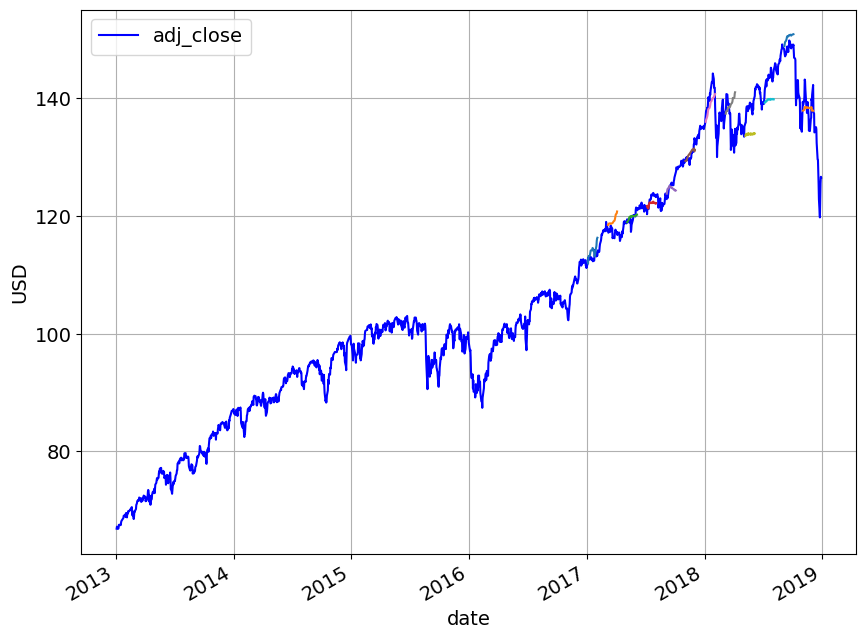

In [1252]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")

(17167.0, 17896.0)

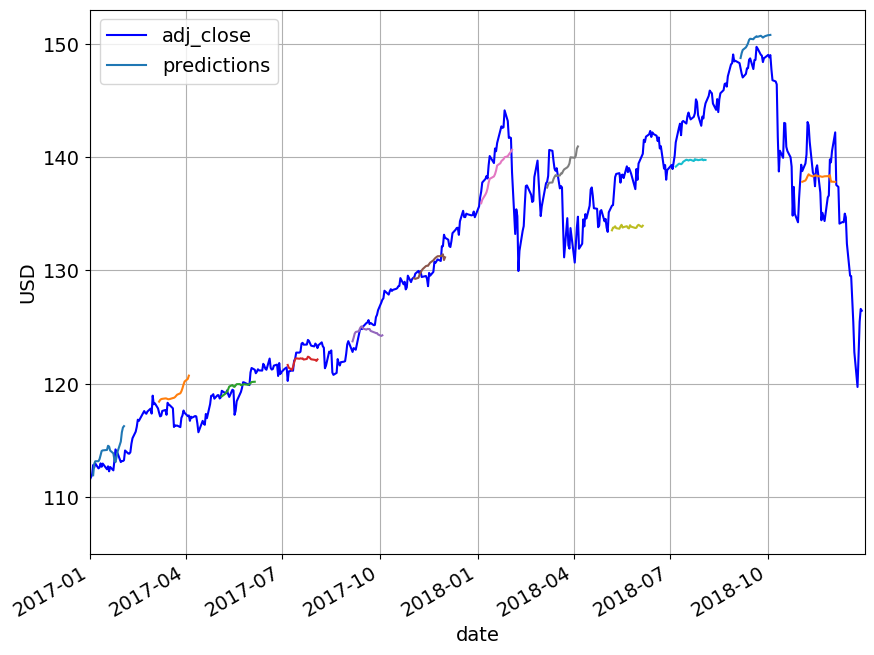

In [1255]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 153])
ax.set_xlim([date(2017, 1, 1), date(2018, 12, 31)])

# Predict for a specific H (forecast horizon), and various dates, tuning model for every prediction

In [ ]:
# i_list = [train_val_size+294, train_val_size+378, train_val_size+462]
# for i in i_list:
#     print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_nprophet.iloc[i]['ds'], H))

#     # Predict using Prophet, and compute error metrics also
#     rmse = [] # root mean square error
#     mape = [] # mean absolute percentage error
#     mae = []  # mean absolute error
#     preds_dict = {}

#     tic = time.time()
    
#     changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
#         hyperparam_tune_cp_fo_wd(df_nprophet[i-train_val_size:i], 
#                                  H, 
#                                  train_size, 
#                                  val_size, 
#                                  changepoint_prior_scale_list,
#                                  fourier_order_list,
#                                  window_list,
#                                  hols)
    
#     # Get predictions using tuned hyperparams
#     if (window_opt is None) or (np.isnan(window_opt)):
#         preds_list = get_preds_prophet(df_nprophet[i-train_val_size:i], 
#                                        H, 
#                                        changepoint_prior_scale_opt, 
#                                        fourier_order_opt, 
#                                        holidays=None)
#     else:
#         hols['lower_window'] = -window_opt
#         hols['upper_window'] = +window_opt
#         preds_list = get_preds_prophet(df_nprophet[i-train_val_size:i], 
#                                        H, 
#                                        changepoint_prior_scale_opt, 
#                                        fourier_order_opt, 
#                                        holidays=hols)
    
#     # Compute error metrics
#     rmse = get_rmse(df_nprophet[i:i+H]['y'], preds_list)
#     mape = get_mape(df_nprophet[i:i+H]['y'], preds_list)
#     mae = get_mae(df_nprophet[i:i+H]['y'], preds_list)

#     # Put results into pickle
#     pickle.dump(preds_list, open("./data/preds_list_" + str(i) + ".pickle", "wb"))
#     pickle.dump(rmse, open("./data/rmse_" + str(i) + ".pickle", "wb"))
#     pickle.dump(mape, open("./data/mape_" + str(i) + ".pickle", "wb"))
#     pickle.dump(mae, open("./data/mae_" + str(i) + ".pickle", "wb"))
#     pickle.dump(changepoint_prior_scale_opt, open("./data/changepoint_prior_scale_opt_" + str(i) + ".pickle", "wb"))
#     pickle.dump(fourier_order_opt, open("./data/fourier_order_opt_" + str(i) + ".pickle", "wb"))
#     pickle.dump(window_opt, open("./data/window_opt_" + str(i) + ".pickle", "wb"))
#     pickle.dump(results, open("./data/results_" + str(i) + ".pickle", "wb"))
    
#     toc = time.time()
#     print("Time taken = " + str((toc-tic)/60.0))

In [ ]:
# # Load pickle file
# i_list = range(train_val_size, train_val_size+84*5+42+1, 42)
# # i_list = [train_val_size, train_val_size+42, train_val_size+84, train_val_size+126, train_val_size+84*2, 
# #           train_val_size+210, train_val_size+84*3, train_val_size+84*4, train_val_size+84*5]
# preds_dict = {}
# rmse, mape, mae, changepoint_prior_scale_opt, fourier_order_opt, window_opt = [], [], [], [], [], []

# for i in i_list:
#     preds_dict[i] = pickle.load(open( "./data/preds_list_" + str(i) + ".pickle", "rb"))
#     rmse.append(pickle.load(open( "./data/rmse_" + str(i) + ".pickle", "rb")))
#     mape.append(pickle.load(open( "./data/mape_" + str(i) + ".pickle", "rb")))
#     mae.append(pickle.load(open( "./data/mae_" + str(i) + ".pickle", "rb")))
#     changepoint_prior_scale_opt.append(pickle.load(open( "./data/changepoint_prior_scale_opt_" + str(i) + ".pickle", "rb")))
#     fourier_order_opt.append(pickle.load(open( "./data/fourier_order_opt_" + str(i) + ".pickle", "rb")))
#     window_opt.append(pickle.load(open( "./data/window_opt_" + str(i) + ".pickle", "rb")))

In [ ]:
# print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
# print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
# print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

In [ ]:
# results_final = pd.DataFrame({'day': i_list,
#                               'changepoint_opt': changepoint_prior_scale_opt,
#                               'fourier_order_opt': fourier_order_opt,
#                               'window_opt': window_opt,
#                               'rmse': rmse,
#                               'mape': mape,
#                               'mae': mae})
# results_final

In [ ]:
# # Plot the predictions, and zoom in
# rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# # Plot the predictions
# for key in preds_dict:
#     ax.plot(df['date'][key:key+H], preds_dict[key])
    
# ax.set_xlabel("date")
# ax.set_ylabel("USD")
# ax.set_ylim([105, 150])
# ax.set_xlim([date(2017, 1, 1), date(2018, 12, 31)])

# Findings


In [1247]:
# Consolidate results from hyperparameter tuning
# pd.set_option('display.max_colwidth', -1)  # or 199
results = pd.DataFrame({'Method': ['Last Value', 
                                   'NeuralProphet - no hyperparameter tuning', 
                                   'NeuralProphet tuning n_changepoints', 
                                   'NeuralProphet tuning fourier order', 
                                   'NeuralProphet tuning window size', 
                                   'NeuralProphet tuning n_lags',
                                   'NeuralProphet tuning all hyperparameters above'],
                        'RMSE'    : [1.89, 1.60, 2.75, 2.19, 2.05, 1.18, 1.04],
                        'MAPE(%)' : [1.59, 1.35, 2.35, 1.87, 1.74, 0.89, 0.81],
                        'MAE'     : [1.80, 1.52, 2.65, 2.12, 1.96, 1.01, 0.91]                       
                       })
results

,Method,RMSE,MAPE(%),MAE
0,Last Value,1.89,1.59,1.80
1,NeuralProphet - no hyperparameter tuning,1.60,1.35,1.52
2,NeuralProphet tuning n_changepoints,2.75,2.35,2.65
3,NeuralProphet tuning fourier order,2.19,1.87,2.12
4,NeuralProphet tuning window size,2.05,1.74,1.96
5,NeuralProphet tuning n_lags,1.18,0.89,1.01
6,NeuralProphet tuning all hyperparameters above,1.04,0.81,0.91
